In [51]:
# Model DLinear
from re import X
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class Model(nn.Module):
    """
    DLinear
    """
    def __init__(self, configs):
        super(Model, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len

        # Decompsition Kernel Size
        kernel_size = 25
        self.decompsition = series_decomp(kernel_size)
        self.individual = configs.individual
        self.channels = configs.enc_in

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()
            self.Linear_Decoder = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Seasonal[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                self.Linear_Decoder.append(nn.Linear(self.seq_len,self.pred_len))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Decoder = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
            self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.pred_len],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]

In [52]:
#TimeSeriesDataset class
from torch.utils.data import DataLoader, Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len, pred_len):
        self.data = data
        self.seq_len = seq_len
        self.pred_len = pred_len

    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len + 1

    def __getitem__(self, index):
        x = self.data[index : index + self.seq_len]
        y = self.data[index + self.seq_len : index + self.seq_len + self.pred_len]
       
        return x, y

In [53]:
#fit function
def fit(model, train_data, test_data, seq_len, pred_len, batch_size, num_epochs, learning_rate):
    # Create DataLoaders
    train_dataset = TimeSeriesDataset(train_data, seq_len, pred_len)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = TimeSeriesDataset(test_data, seq_len, pred_len)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        loop = tqdm(train_loader, leave=True)

        for i, (batch_x, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()

            batch_x = batch_x.float()
            batch_y = batch_y.float()
            output = model(batch_x)

            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            loop.set_description(f'Epoch [{epoch}/{num_epochs}]')
            loop.set_postfix(loss=loss.item())

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for i, (batch_x, batch_y) in enumerate(test_loader):
                batch_x = batch_x.float()
                batch_y = batch_y.float()
                output = model(batch_x)
                loss = criterion(output, batch_y)
                test_loss += loss.item()

        scheduler.step(test_loss)  # Update learning rate based on test loss

        train_loss /= len(train_loader)
        test_loss /= len(test_loader)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    return model

In [54]:
def predict_test(model, test_data, seq_len, pred_len, batch_size):
    test_dataset = TimeSeriesDataset(test_data, seq_len, pred_len)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    # Initialize an empty list to store the predictions
    test_pred = []

    # Iterate over the test data
    for i, (batch_x, batch_y) in enumerate(test_loader):
        batch_x = batch_x.float()
        batch_y = batch_y.float()

        # Make predictions
        with torch.no_grad():
            output = model(batch_x)

        # Append the predictions to the list
        test_pred.append(output)

    # Concatenate the predictions into a single tensor
    test_pred_tensor = torch.cat(test_pred, dim=0)

    # Select the last prediction from each sequence
    test_pred_1 = test_pred_tensor[:, -1, :]

    # Detach and convert to numpy array
    test_pred_1 = test_pred_1.detach().cpu().numpy()

    # Inverse transform the predictions

    return test_pred_1

In [55]:
#predict 30 days function
def predict(model, test_data, seq_len, prediction_days=30):
    # Lấy những phần tử cuối cùng có độ dài seq_len
    last_days = test_data[-seq_len:]
    # Chuyển đổi thành tensor và thêm một chiều
    input_x = torch.tensor(last_days).float().unsqueeze(0)
    # Khởi tạo một danh sách để lưu trữ các dự đoán
    predictions = []

    for _ in range(prediction_days):
        with torch.no_grad():
            # Dự đoán cho ngày tiếp theo
            output = model(input_x)
            
            # Lấy dự đoán cuối cùng
            last_output = output[:, -1, :]
            
            # Thêm dự đoán vào danh sách
            predictions.append(last_output)
            
            # Thêm dự đoán vào input cho bước tiếp theo
            input_x = torch.cat((input_x[:, 1:, :], last_output.unsqueeze(0)), dim=1)

    # Chuyển đổi danh sách dự đoán thành tensor
    predictions_tensor = torch.cat(predictions, dim=0)

    return predictions_tensor

In [56]:
#read data
import pandas as pd
# Đọc dữ liệu từ file CSV
## HaNoi
df_Hanoi = pd.read_csv('data/AQI_Hanoi_Done.csv')
df1_HaNoi=df_Hanoi.reset_index()['AQI']

## DaNang
df_DaNang = pd.read_csv('data/AQI_DaNang_Done.csv')
df1_DaNang=df_DaNang.reset_index()['AQI']

## VietTri
df_VietTri = pd.read_csv('data/AQI_VietTri_Done.csv')
df1_VietTri=df_VietTri.reset_index()['AQI']

In [57]:
# Scaler data
from sklearn.preprocessing import MinMaxScaler
import numpy as np
scaler=MinMaxScaler(feature_range=(0,1))

df1_HaNoi =scaler.fit_transform(np.array(df1_HaNoi).reshape(-1,1))
df1_DaNang =scaler.fit_transform(np.array(df1_DaNang).reshape(-1,1))
df1_VietTri =scaler.fit_transform(np.array(df1_VietTri).reshape(-1,1))


In [58]:
class Configs:
    enc_in = 1
    dec_in = 1
    seq_len = 48
    pred_len = 1
    individual = False
configs = Configs()
model = Model(configs)

### Với tỉ lệ 7 - 3

In [59]:
#splitting dataset into train and test split
split_size = 0.7

## HaNoi
train_size= int(split_size * len(df_Hanoi))
test_size = int((1-split_size) * len(df_Hanoi))

train_data_HaNoi = df1_HaNoi[:train_size]
test_data_HaNoi = df1_HaNoi[train_size:train_size+test_size]

## DaNang
train_size= int(split_size * len(df_DaNang))
test_size = int((1-split_size) * len(df_DaNang))

train_data_DaNang = df1_DaNang[:train_size]
test_data_DaNang = df1_DaNang[train_size:train_size+test_size]

## VietTri
train_size= int(split_size * len(df_VietTri))
test_size = int((1-split_size) * len(df_VietTri))

train_data_VietTri = df1_VietTri[:train_size]
test_data_VietTri = df1_VietTri[train_size:train_size+test_size]



In [60]:
#train model
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from tqdm import tqdm
# Hyperparameters
seq_len = configs.seq_len  
pred_len =  configs.pred_len
batch_size = 64
num_epochs = 100
learning_rate = 0.003
individual = False


#fit model for HaNoi
model_HaNoi = fit(model, train_data_HaNoi, test_data_HaNoi, seq_len, pred_len, batch_size, num_epochs, learning_rate)

#fit model for DaNang
model_DaNang = fit(model, train_data_DaNang, test_data_DaNang, seq_len, pred_len, batch_size, num_epochs, learning_rate)

#fit model for VietTri
model_VietTri = fit(model, train_data_VietTri, test_data_VietTri, seq_len, pred_len, batch_size, num_epochs, learning_rate)


c:\Users\Hung\miniconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch [0/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0208]

Epoch 1/100, Train Loss: 0.0238, Test Loss: 0.0224


Epoch [0/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0208]


Epoch 2/100, Train Loss: 0.0183, Test Loss: 0.0235


Epoch [2/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.019] 

Epoch 3/100, Train Loss: 0.0161, Test Loss: 0.0175


Epoch [2/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.019]


Epoch 4/100, Train Loss: 0.0145, Test Loss: 0.0170


Epoch [4/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0131] 

Epoch 5/100, Train Loss: 0.0141, Test Loss: 0.0162


Epoch [4/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0131]


Epoch 6/100, Train Loss: 0.0139, Test Loss: 0.0162


Epoch [6/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0112] 

Epoch 7/100, Train Loss: 0.0139, Test Loss: 0.0160


Epoch [6/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0112]


Epoch 8/100, Train Loss: 0.0137, Test Loss: 0.0159


Epoch [8/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00983]

Epoch 9/100, Train Loss: 0.0135, Test Loss: 0.0158


Epoch [8/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00983]


Epoch 10/100, Train Loss: 0.0137, Test Loss: 0.0162


Epoch [10/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0161] 

Epoch 11/100, Train Loss: 0.0139, Test Loss: 0.0162


Epoch [10/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0161]


Epoch 12/100, Train Loss: 0.0137, Test Loss: 0.0158


Epoch [12/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0199] 

Epoch 13/100, Train Loss: 0.0137, Test Loss: 0.0164


Epoch [12/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0199]


Epoch 14/100, Train Loss: 0.0138, Test Loss: 0.0159


Epoch [14/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.017]  

Epoch 15/100, Train Loss: 0.0141, Test Loss: 0.0162


Epoch [14/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.017]


Epoch 16/100, Train Loss: 0.0136, Test Loss: 0.0160


Epoch [16/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.014]  

Epoch 17/100, Train Loss: 0.0139, Test Loss: 0.0163


Epoch [16/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.014]


Epoch 18/100, Train Loss: 0.0139, Test Loss: 0.0171


Epoch [18/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0142] 

Epoch 19/100, Train Loss: 0.0135, Test Loss: 0.0162


Epoch [18/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0142]


Epoch 20/100, Train Loss: 0.0136, Test Loss: 0.0160


Epoch [20/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0123] 

Epoch 21/100, Train Loss: 0.0136, Test Loss: 0.0159


Epoch [20/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0123]


Epoch 22/100, Train Loss: 0.0135, Test Loss: 0.0161


Epoch [22/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00923]

Epoch 23/100, Train Loss: 0.0135, Test Loss: 0.0161


Epoch [22/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00923]


Epoch 24/100, Train Loss: 0.0135, Test Loss: 0.0163


Epoch [24/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0105] 

Epoch 25/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [24/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0105]


Epoch 26/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [26/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0142] 

Epoch 27/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [26/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0142]


Epoch 28/100, Train Loss: 0.0135, Test Loss: 0.0159


Epoch [28/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0146] 

Epoch 29/100, Train Loss: 0.0135, Test Loss: 0.0160


Epoch [28/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0146]


Epoch 30/100, Train Loss: 0.0134, Test Loss: 0.0161


Epoch [30/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0113] 

Epoch 31/100, Train Loss: 0.0134, Test Loss: 0.0160


Epoch [30/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0113]


Epoch 32/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [32/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0112] 

Epoch 33/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [32/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0112]


Epoch 34/100, Train Loss: 0.0134, Test Loss: 0.0160


Epoch [34/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00716]

Epoch 35/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [34/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00716]


Epoch 36/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [36/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00878]

Epoch 37/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [36/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00878]


Epoch 38/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [38/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0174] 

Epoch 39/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [38/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0174]


Epoch 40/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [40/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0143] 

Epoch 41/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [40/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0143]


Epoch 42/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [42/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0182] 

Epoch 43/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [42/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0182]


Epoch 44/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [44/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.013]  

Epoch 45/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [44/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.013]


Epoch 46/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [46/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0158] 

Epoch 47/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [46/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0158]


Epoch 48/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [48/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0111] 

Epoch 49/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [48/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0111]


Epoch 50/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [50/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0157] 

Epoch 51/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [50/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0157]


Epoch 52/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [52/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0102]

Epoch 53/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [52/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0102]


Epoch 54/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [54/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0165] 

Epoch 55/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [54/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0165]


Epoch 56/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [56/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0124] 

Epoch 57/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [56/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0124]


Epoch 58/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [58/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00985]

Epoch 59/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [58/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00985]


Epoch 60/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [60/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0175] 

Epoch 61/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [60/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0175]


Epoch 62/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [62/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0108] 

Epoch 63/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [62/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0108]


Epoch 64/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [64/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0109] 

Epoch 65/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [64/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0109]


Epoch 66/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [66/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0166] 

Epoch 67/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [66/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0166]


Epoch 68/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [68/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0126] 

Epoch 69/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [68/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0126]


Epoch 70/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [70/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0175] 

Epoch 71/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [70/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0175]


Epoch 72/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [72/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0106] 

Epoch 73/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [72/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0106]


Epoch 74/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [74/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0108] 

Epoch 75/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [74/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0108]


Epoch 76/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [76/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0127] 

Epoch 77/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [76/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0127]


Epoch 78/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [78/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0191] 

Epoch 79/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [78/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0191]


Epoch 80/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [80/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0159] 

Epoch 81/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [80/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0159]


Epoch 82/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [82/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0141] 

Epoch 83/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [82/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0141]


Epoch 84/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [84/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0144] 

Epoch 85/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [84/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0144]


Epoch 86/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [86/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0149] 

Epoch 87/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [86/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0149]


Epoch 88/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [88/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0115] 

Epoch 89/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [88/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0115]


Epoch 90/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [90/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0103] 

Epoch 91/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [90/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0103]


Epoch 92/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [92/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0165] 

Epoch 93/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [92/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0165]


Epoch 94/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [94/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0129] 

Epoch 95/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [94/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0129]


Epoch 96/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [96/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0207] 

Epoch 97/100, Train Loss: 0.0134, Test Loss: 0.0159


Epoch [96/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0207]


Epoch 98/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [98/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0113] 

Epoch 99/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [99/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00832]


Epoch 100/100, Train Loss: 0.0133, Test Loss: 0.0159


Epoch [0/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00721]

Epoch 1/100, Train Loss: 0.0081, Test Loss: 0.0099


Epoch [0/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00721]


Epoch 2/100, Train Loss: 0.0073, Test Loss: 0.0103


Epoch [2/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00542]

Epoch 3/100, Train Loss: 0.0074, Test Loss: 0.0103


Epoch [2/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00542]


Epoch 4/100, Train Loss: 0.0073, Test Loss: 0.0106


Epoch [4/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.006]  

Epoch 5/100, Train Loss: 0.0072, Test Loss: 0.0103


Epoch [4/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.006]


Epoch 6/100, Train Loss: 0.0073, Test Loss: 0.0105


Epoch [6/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00812]

Epoch 7/100, Train Loss: 0.0075, Test Loss: 0.0103


Epoch [6/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00812]


Epoch 8/100, Train Loss: 0.0070, Test Loss: 0.0103


Epoch [8/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00704]

Epoch 9/100, Train Loss: 0.0070, Test Loss: 0.0103


Epoch [8/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00704]


Epoch 10/100, Train Loss: 0.0070, Test Loss: 0.0103


Epoch [10/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00675]

Epoch 11/100, Train Loss: 0.0071, Test Loss: 0.0104


Epoch [10/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00675]


Epoch 12/100, Train Loss: 0.0070, Test Loss: 0.0108


Epoch [12/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00486]

Epoch 13/100, Train Loss: 0.0071, Test Loss: 0.0103


Epoch [12/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00486]


Epoch 14/100, Train Loss: 0.0070, Test Loss: 0.0104


Epoch [14/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00464]

Epoch 15/100, Train Loss: 0.0070, Test Loss: 0.0105


Epoch [14/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00464]


Epoch 16/100, Train Loss: 0.0070, Test Loss: 0.0103


Epoch [16/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0066] 

Epoch 17/100, Train Loss: 0.0070, Test Loss: 0.0103


Epoch [16/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0066]


Epoch 18/100, Train Loss: 0.0070, Test Loss: 0.0106


Epoch [18/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00607]

Epoch 19/100, Train Loss: 0.0071, Test Loss: 0.0106


Epoch [18/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00607]


Epoch 20/100, Train Loss: 0.0070, Test Loss: 0.0104


Epoch [20/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00602]

Epoch 21/100, Train Loss: 0.0070, Test Loss: 0.0104


Epoch [20/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00602]


Epoch 22/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [22/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00542]

Epoch 23/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [22/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00542]


Epoch 24/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [24/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0089] 

Epoch 25/100, Train Loss: 0.0070, Test Loss: 0.0104


Epoch [24/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0089]


Epoch 26/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [26/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00581]

Epoch 27/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [26/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00581]


Epoch 28/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [28/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00693]

Epoch 29/100, Train Loss: 0.0070, Test Loss: 0.0104


Epoch [28/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00693]


Epoch 30/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [30/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00506]

Epoch 31/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [30/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00506]


Epoch 32/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [32/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00474]

Epoch 33/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [32/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00474]


Epoch 34/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [34/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0105] 

Epoch 35/100, Train Loss: 0.0070, Test Loss: 0.0104


Epoch [34/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0105]


Epoch 36/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [36/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00561]

Epoch 37/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [36/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00561]


Epoch 38/100, Train Loss: 0.0070, Test Loss: 0.0104


Epoch [38/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00594]

Epoch 39/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [38/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00594]


Epoch 40/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [40/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00707]

Epoch 41/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [40/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00707]


Epoch 42/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [42/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00515]

Epoch 43/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [42/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00515]


Epoch 44/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [44/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00599]

Epoch 45/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [44/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00599]


Epoch 46/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [46/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00663]

Epoch 47/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [46/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00663]


Epoch 48/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [48/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0051] 

Epoch 49/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [48/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0051]


Epoch 50/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [50/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00517]

Epoch 51/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [50/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00517]


Epoch 52/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [52/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00551]

Epoch 53/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [52/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00551]


Epoch 54/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [54/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00472]

Epoch 55/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [54/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00472]


Epoch 56/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [56/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00575]

Epoch 57/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [56/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00575]


Epoch 58/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [58/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0045] 

Epoch 59/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [58/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0045]


Epoch 60/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [60/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00977]

Epoch 61/100, Train Loss: 0.0070, Test Loss: 0.0104


Epoch [60/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00977]


Epoch 62/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [62/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00548]

Epoch 63/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [62/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00548]


Epoch 64/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [64/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0071] 

Epoch 65/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [64/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0071]


Epoch 66/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [66/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00827]

Epoch 67/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [66/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00827]


Epoch 68/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [68/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00369]

Epoch 69/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [68/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00369]


Epoch 70/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [70/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0045] 

Epoch 71/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [70/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0045]


Epoch 72/100, Train Loss: 0.0070, Test Loss: 0.0104


Epoch [72/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00868]

Epoch 73/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [72/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00868]


Epoch 74/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [74/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00632]

Epoch 75/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [74/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00632]


Epoch 76/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [76/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00574]

Epoch 77/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [76/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00574]


Epoch 78/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [78/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0102] 

Epoch 79/100, Train Loss: 0.0070, Test Loss: 0.0104


Epoch [78/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0102]


Epoch 80/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [80/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00736]

Epoch 81/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [80/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00736]


Epoch 82/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [82/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.01]   

Epoch 83/100, Train Loss: 0.0070, Test Loss: 0.0104


Epoch [82/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.01]


Epoch 84/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [84/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00499]

Epoch 85/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [84/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00499]


Epoch 86/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [86/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00671]

Epoch 87/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [86/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00671]


Epoch 88/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [88/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00387]

Epoch 89/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [88/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00387]


Epoch 90/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [90/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00796]

Epoch 91/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [90/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00796]


Epoch 92/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [92/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00517]

Epoch 93/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [92/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00517]


Epoch 94/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [94/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00515]

Epoch 95/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [94/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00515]


Epoch 96/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [96/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00908]

Epoch 97/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [96/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00908]


Epoch 98/100, Train Loss: 0.0070, Test Loss: 0.0104


Epoch [98/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0064] 

Epoch 99/100, Train Loss: 0.0069, Test Loss: 0.0104


Epoch [99/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.016]


Epoch 100/100, Train Loss: 0.0070, Test Loss: 0.0104


Epoch [0/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0175]

Epoch 1/100, Train Loss: 0.0159, Test Loss: 0.0180


Epoch [0/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0175]


Epoch 2/100, Train Loss: 0.0149, Test Loss: 0.0173


Epoch [2/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0177]

Epoch 3/100, Train Loss: 0.0140, Test Loss: 0.0161


Epoch [2/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0177]


Epoch 4/100, Train Loss: 0.0137, Test Loss: 0.0181


Epoch [4/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0206]

Epoch 5/100, Train Loss: 0.0139, Test Loss: 0.0163


Epoch [4/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0206]


Epoch 6/100, Train Loss: 0.0138, Test Loss: 0.0168


Epoch [6/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0149] 

Epoch 7/100, Train Loss: 0.0135, Test Loss: 0.0167


Epoch [6/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0149]


Epoch 8/100, Train Loss: 0.0136, Test Loss: 0.0165


Epoch [8/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0213] 

Epoch 9/100, Train Loss: 0.0136, Test Loss: 0.0184


Epoch [8/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0213]


Epoch 10/100, Train Loss: 0.0138, Test Loss: 0.0166


Epoch [10/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0159] 

Epoch 11/100, Train Loss: 0.0135, Test Loss: 0.0169


Epoch [10/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0159]


Epoch 12/100, Train Loss: 0.0135, Test Loss: 0.0166


Epoch [12/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0159] 

Epoch 13/100, Train Loss: 0.0136, Test Loss: 0.0166


Epoch [12/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0159]


Epoch 14/100, Train Loss: 0.0135, Test Loss: 0.0167


Epoch [14/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00901]

Epoch 15/100, Train Loss: 0.0134, Test Loss: 0.0170


Epoch [14/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00901]


Epoch 16/100, Train Loss: 0.0135, Test Loss: 0.0170


Epoch [16/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00868]

Epoch 17/100, Train Loss: 0.0134, Test Loss: 0.0169


Epoch [16/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00868]


Epoch 18/100, Train Loss: 0.0133, Test Loss: 0.0167


Epoch [18/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0102] 

Epoch 19/100, Train Loss: 0.0134, Test Loss: 0.0170


Epoch [18/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0102]


Epoch 20/100, Train Loss: 0.0134, Test Loss: 0.0174


Epoch [20/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0152] 

Epoch 21/100, Train Loss: 0.0137, Test Loss: 0.0166


Epoch [20/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0152]


Epoch 22/100, Train Loss: 0.0135, Test Loss: 0.0167


Epoch [22/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0204] 

Epoch 23/100, Train Loss: 0.0135, Test Loss: 0.0169


Epoch [22/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0204]


Epoch 24/100, Train Loss: 0.0134, Test Loss: 0.0166


Epoch [24/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00967]

Epoch 25/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [24/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00967]


Epoch 26/100, Train Loss: 0.0134, Test Loss: 0.0167


Epoch [26/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00925]

Epoch 27/100, Train Loss: 0.0134, Test Loss: 0.0167


Epoch [26/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00925]


Epoch 28/100, Train Loss: 0.0134, Test Loss: 0.0167


Epoch [28/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0139] 

Epoch 29/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [28/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0139]


Epoch 30/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [30/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00796]

Epoch 31/100, Train Loss: 0.0133, Test Loss: 0.0167


Epoch [30/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00796]


Epoch 32/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [32/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0137] 

Epoch 33/100, Train Loss: 0.0134, Test Loss: 0.0169


Epoch [32/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0137]


Epoch 34/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [34/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0116] 

Epoch 35/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [34/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0116]


Epoch 36/100, Train Loss: 0.0133, Test Loss: 0.0167


Epoch [36/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00792]

Epoch 37/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [36/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00792]


Epoch 38/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [38/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0157] 

Epoch 39/100, Train Loss: 0.0133, Test Loss: 0.0167


Epoch [38/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0157]


Epoch 40/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [40/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0107]

Epoch 41/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [40/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0107]


Epoch 42/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [42/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0103] 

Epoch 43/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [42/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0103]


Epoch 44/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [44/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0121] 

Epoch 45/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [44/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0121]


Epoch 46/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [46/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0157] 

Epoch 47/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [46/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0157]


Epoch 48/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [48/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00913]

Epoch 49/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [48/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00913]


Epoch 50/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [50/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0104] 

Epoch 51/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [50/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0104]


Epoch 52/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [52/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0112] 

Epoch 53/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [52/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0112]


Epoch 54/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [54/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0107] 

Epoch 55/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [54/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0107]


Epoch 56/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [56/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0189] 

Epoch 57/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [56/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0189]


Epoch 58/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [58/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0119] 

Epoch 59/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [58/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0119]


Epoch 60/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [60/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0141] 

Epoch 61/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [60/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0141]


Epoch 62/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [62/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0119] 

Epoch 63/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [62/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0119]


Epoch 64/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [64/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00982]

Epoch 65/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [64/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00982]


Epoch 66/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [66/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00875]

Epoch 67/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [66/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00875]


Epoch 68/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [68/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0148] 

Epoch 69/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [68/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0148]


Epoch 70/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [70/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0131] 

Epoch 71/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [70/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0131]


Epoch 72/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [72/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.012]  

Epoch 73/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [72/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.012]


Epoch 74/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [74/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0141] 

Epoch 75/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [74/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0141]


Epoch 76/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [76/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0163] 

Epoch 77/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [76/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0163]


Epoch 78/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [78/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0099] 

Epoch 79/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [78/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0099]


Epoch 80/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [80/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0175] 

Epoch 81/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [80/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0175]


Epoch 82/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [82/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0109] 

Epoch 83/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [82/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0109]


Epoch 84/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [84/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0149] 

Epoch 85/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [84/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0149]


Epoch 86/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [86/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0102] 

Epoch 87/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [86/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0102]


Epoch 88/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [88/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0117] 

Epoch 89/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [88/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0117]


Epoch 90/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [90/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0104] 

Epoch 91/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [90/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0104]


Epoch 92/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [92/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.013]  

Epoch 93/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [92/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.013]


Epoch 94/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [94/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0104]

Epoch 95/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [94/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0104]


Epoch 96/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [96/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0126] 

Epoch 97/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [96/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0126]


Epoch 98/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [98/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00952]

Epoch 99/100, Train Loss: 0.0133, Test Loss: 0.0168


Epoch [99/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0137]

Epoch 100/100, Train Loss: 0.0133, Test Loss: 0.0168


In [61]:
# Make predictions on the test data
test_pred_HaNoi = predict_test(model_HaNoi, test_data_HaNoi, seq_len, pred_len, batch_size)
test_pred_DaNang = predict_test(model_DaNang, test_data_DaNang, seq_len, pred_len, batch_size)
test_pred_VietTri = predict_test(model_VietTri, test_data_VietTri, seq_len, pred_len, batch_size)
# Inverse transform the predictions
test_pred_HaNoi = scaler.inverse_transform(test_pred_HaNoi)
test_pred_DaNang = scaler.inverse_transform(test_pred_DaNang)
test_pred_VietTri = scaler.inverse_transform(test_pred_VietTri)
print(test_pred_HaNoi)


[[ 75.11849 ]
 [ 63.398148]
 [ 54.54456 ]
 [ 51.118225]
 [ 57.990387]
 [ 60.82013 ]
 [ 68.13762 ]
 [ 76.39004 ]
 [ 66.70222 ]
 [ 58.619576]
 [ 57.447845]
 [ 47.43987 ]
 [ 77.39981 ]
 [ 71.90519 ]
 [ 82.69459 ]
 [ 91.97173 ]
 [ 80.811646]
 [ 96.635025]
 [ 74.84726 ]
 [ 75.1191  ]
 [ 81.3607  ]
 [ 59.706635]
 [ 53.508854]
 [ 67.89052 ]
 [ 82.269615]
 [109.3936  ]
 [ 89.46387 ]
 [114.134895]
 [ 87.01786 ]
 [ 86.83739 ]
 [ 97.896126]
 [ 95.118866]
 [ 67.87275 ]
 [ 61.433197]
 [ 73.15763 ]
 [ 59.986275]
 [ 42.682953]
 [ 43.866123]
 [ 54.91164 ]
 [ 59.61102 ]
 [ 94.73009 ]
 [108.307625]
 [111.69356 ]
 [ 99.96465 ]
 [ 78.38977 ]
 [ 85.217606]
 [ 86.24661 ]
 [ 74.668304]
 [ 70.38277 ]
 [ 58.819782]
 [ 48.6793  ]
 [ 53.902313]
 [ 68.34468 ]
 [100.88321 ]
 [100.82263 ]
 [ 91.54308 ]
 [ 71.256546]
 [ 71.67    ]
 [ 64.28402 ]
 [ 56.29507 ]
 [ 50.241302]
 [ 43.968334]
 [ 37.148506]
 [ 38.89081 ]
 [ 39.329926]
 [ 53.405457]
 [ 45.045372]
 [ 45.002953]
 [ 73.01905 ]
 [ 88.08062 ]
 [ 79.3599  ]
 [ 72.

In [62]:
## Make predictions for the next 30 days
prediction_days = 30
predictions_HaNoi_30 = predict(model_HaNoi, test_data_HaNoi, configs.seq_len, prediction_days)
predictions_DaNang_30 = predict(model_DaNang, test_data_DaNang, configs.seq_len, prediction_days)
predictions_VietTri_30 = predict(model_VietTri, test_data_VietTri, configs.seq_len, prediction_days)

# Inverse transform the predictions
predictions_HaNoi_30 = scaler.inverse_transform(predictions_HaNoi_30)
predictions_DaNang_30 = scaler.inverse_transform(predictions_DaNang_30)
predictions_VietTri_30 = scaler.inverse_transform(predictions_VietTri_30)

## Make predictions for the next 60 days
prediction_days = 60
predictions_HaNoi_60 = predict(model_HaNoi, test_data_HaNoi, configs.seq_len, prediction_days)
predictions_DaNang_60 = predict(model_DaNang, test_data_DaNang, configs.seq_len, prediction_days)
predictions_VietTri_60 = predict(model_VietTri, test_data_VietTri, configs.seq_len, prediction_days)

# Inverse transform the predictions
predictions_HaNoi_60 = scaler.inverse_transform(predictions_HaNoi_60)
predictions_DaNang_60 = scaler.inverse_transform(predictions_DaNang_60)
predictions_VietTri_60 = scaler.inverse_transform(predictions_VietTri_60)

## Make predictions for the next 90 days

prediction_days = 90
predictions_HaNoi_90 = predict(model_HaNoi, test_data_HaNoi, configs.seq_len, prediction_days)
predictions_DaNang_90 = predict(model_DaNang, test_data_DaNang, configs.seq_len, prediction_days)
predictions_VietTri_90 = predict(model_VietTri, test_data_VietTri, configs.seq_len, prediction_days)

# Inverse transform the predictions
predictions_HaNoi_90 = scaler.inverse_transform(predictions_HaNoi_90)
predictions_DaNang_90 = scaler.inverse_transform(predictions_DaNang_90)
predictions_VietTri_90 = scaler.inverse_transform(predictions_VietTri_90)


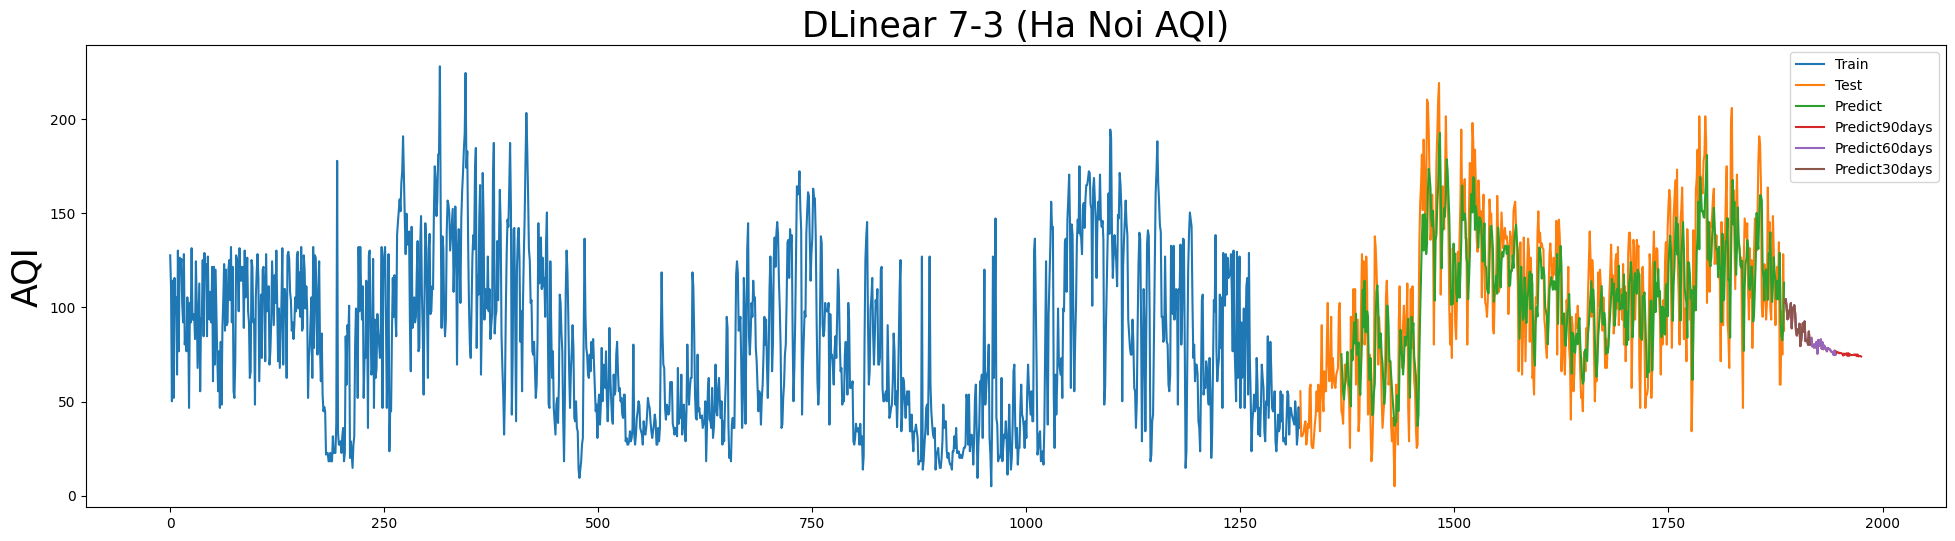

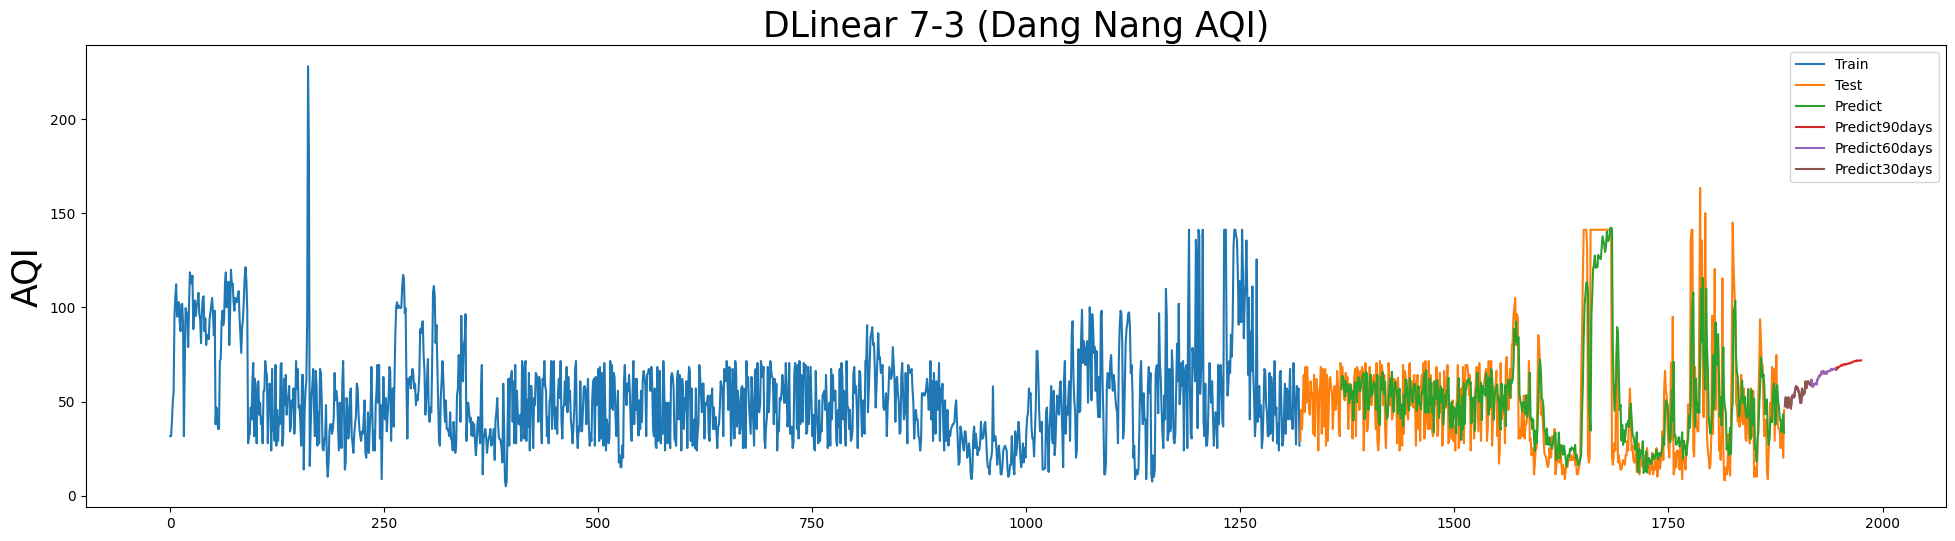

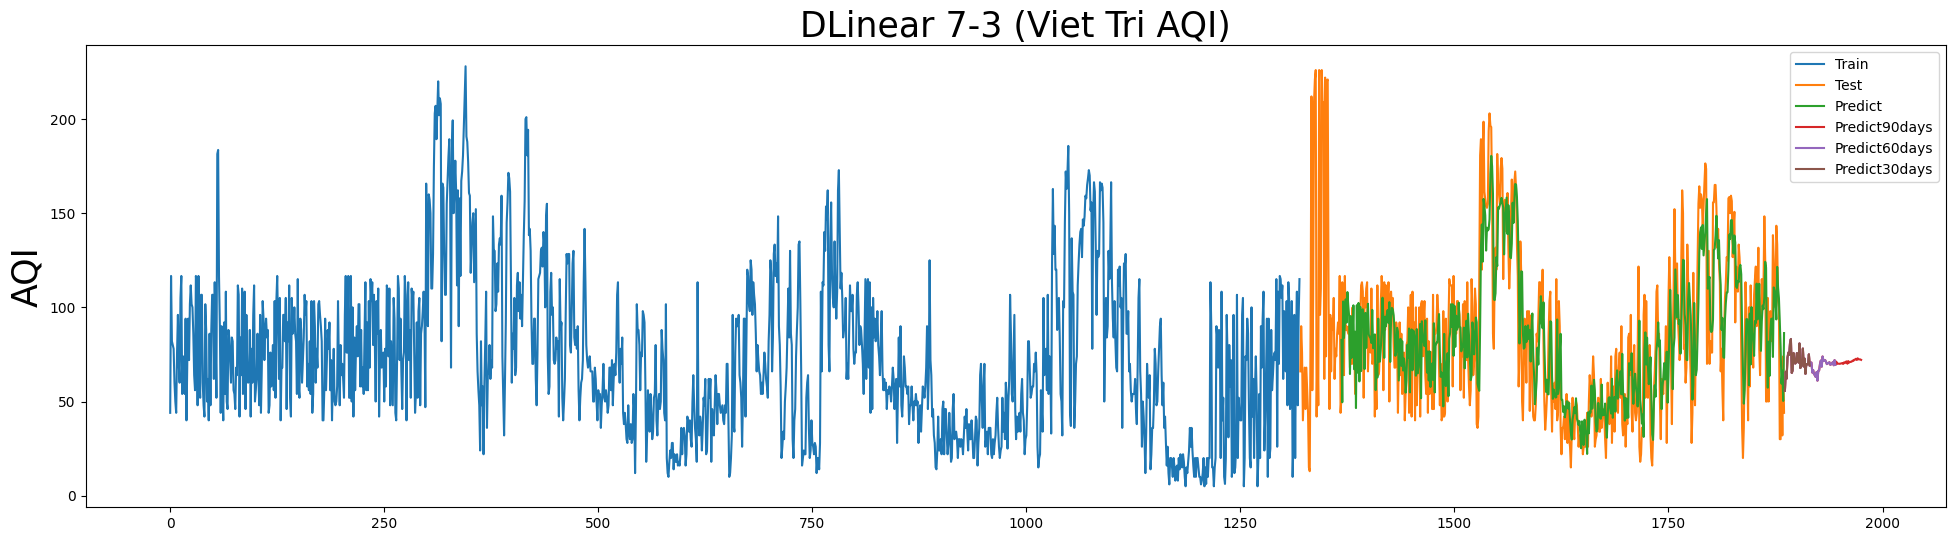

In [63]:
# Visualize the predictions
import matplotlib.pyplot as plt

## HaNoi
train_data_origin = scaler.inverse_transform(train_data_HaNoi)
test_data_origin = scaler.inverse_transform(test_data_HaNoi)
test_pred_origin = test_pred_HaNoi
pred_30_origin = predictions_HaNoi_30
pred_60_origin = predictions_HaNoi_60
pred_90_origin = predictions_HaNoi_90


test_data_index = pd.RangeIndex(start=len(train_data_origin), stop=len(train_data_origin)+len(test_data_origin), step=1)
test_pred_index = pd.RangeIndex(start=len(train_data_origin)+configs.seq_len+configs.pred_len-1, stop=len(train_data_origin)+len(test_data_origin), step=1)
pred_30_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+30, step=1)
pred_60_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+60, step=1)
pred_90_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+90, step=1)

plt.figure(figsize=(24, 6))
plt.title('DLinear 7-3 (Ha Noi AQI)', fontsize=25)
plt.ylabel('AQI', fontsize=25)

plt.plot(train_data_origin)
plt.plot(test_data_index, test_data_origin)
plt.plot(test_pred_index, test_pred_origin)
plt.plot(pred_90_index, pred_90_origin)
plt.plot(pred_60_index, pred_60_origin)
plt.plot(pred_30_index, pred_30_origin)

plt.legend(['Train','Test','Predict','Predict90days','Predict60days','Predict30days'])

#Save plot to file
plt.savefig('plot/DLinear_7-3_HaNoi.png')

## DaNang
train_data_origin = scaler.inverse_transform(train_data_DaNang)
test_data_origin = scaler.inverse_transform(test_data_DaNang)
test_pred_origin = test_pred_DaNang
pred_30_origin = predictions_DaNang_30
pred_60_origin = predictions_DaNang_60
pred_90_origin = predictions_DaNang_90

test_data_index = pd.RangeIndex(start=len(train_data_origin), stop=len(train_data_origin)+len(test_data_origin), step=1)
test_pred_index = pd.RangeIndex(start=len(train_data_origin)+configs.seq_len+configs.pred_len-1, stop=len(train_data_origin)+len(test_data_origin), step=1)
pred_30_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+30, step=1)
pred_60_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+60, step=1)
pred_90_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+90, step=1)

plt.figure(figsize=(24, 6))
plt.title('DLinear 7-3 (Dang Nang AQI)', fontsize=25)
plt.ylabel('AQI', fontsize=25)

plt.plot(train_data_origin)
plt.plot(test_data_index, test_data_origin)
plt.plot(test_pred_index, test_pred_origin)
plt.plot(pred_90_index, pred_90_origin)
plt.plot(pred_60_index, pred_60_origin)
plt.plot(pred_30_index, pred_30_origin)

plt.legend(['Train','Test','Predict','Predict90days','Predict60days','Predict30days'])
#Save plot to file
plt.savefig('plot/DLinear_7-3_DaNang.png')

## VietTri
train_data_origin = scaler.inverse_transform(train_data_VietTri)
test_data_origin = scaler.inverse_transform(test_data_VietTri)
test_pred_origin = test_pred_VietTri
pred_30_origin = predictions_VietTri_30
pred_60_origin = predictions_VietTri_60
pred_90_origin = predictions_VietTri_90

test_data_index = pd.RangeIndex(start=len(train_data_origin), stop=len(train_data_origin)+len(test_data_origin), step=1)
test_pred_index = pd.RangeIndex(start=len(train_data_origin)+configs.seq_len+configs.pred_len-1, stop=len(train_data_origin)+len(test_data_origin), step=1)
pred_30_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+30, step=1)
pred_60_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+60, step=1)
pred_90_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+90, step=1)

plt.figure(figsize=(24, 6))
plt.title('DLinear 7-3 (Viet Tri AQI)', fontsize=25)
plt.ylabel('AQI', fontsize=25)

plt.plot(train_data_origin)
plt.plot(test_data_index, test_data_origin)
plt.plot(test_pred_index, test_pred_origin)
plt.plot(pred_90_index, pred_90_origin)
plt.plot(pred_60_index, pred_60_origin)
plt.plot(pred_30_index, pred_30_origin)

plt.legend(['Train','Test','Predict','Predict90days','Predict60days','Predict30days'])

#Save plot to file
plt.savefig('plot/DLinear_7-3_VietTri.png')



In [64]:
#tính RMSE,MAPE,MAE cho tâp test
from sklearn.metrics import mean_squared_error
from math import sqrt

## HaNoi
print('HaNoi')
test_data_origin = scaler.inverse_transform(test_data_HaNoi)
test_pred_origin = test_pred_HaNoi

test_data_origin_1 = test_data_origin[configs.seq_len+configs.pred_len-1:]
rmse = sqrt(mean_squared_error(test_pred_origin, test_data_origin_1))
mape = np.mean(np.abs((test_pred_origin - test_data_origin_1) /test_data_origin_1)) * 100
mae = np.mean(np.abs(test_pred_origin - test_data_origin_1))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)

print('DaNang')
test_data_origin = scaler.inverse_transform(test_data_DaNang)
test_pred_origin = test_pred_DaNang

test_data_origin_1 = test_data_origin[configs.seq_len+configs.pred_len-1:]
rmse = sqrt(mean_squared_error(test_pred_origin, test_data_origin_1))
mape = np.mean(np.abs((test_pred_origin - test_data_origin_1) /test_data_origin_1)) * 100
mae = np.mean(np.abs(test_pred_origin - test_data_origin_1))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)

## VietTri
print('VietTri')
test_data_origin = scaler.inverse_transform(test_data_VietTri)
test_pred_origin = test_pred_VietTri

test_data_origin_1 = test_data_origin[configs.seq_len+configs.pred_len-1:]
rmse = sqrt(mean_squared_error(test_pred_origin, test_data_origin_1))
mape = np.mean(np.abs((test_pred_origin - test_data_origin_1) /test_data_origin_1)) * 100
mae = np.mean(np.abs(test_pred_origin - test_data_origin_1))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)


HaNoi
Test RMSE: 27.364
Test MAPE: 25.103
Test MAE: 22.145
DaNang
Test RMSE: 22.938
Test MAPE: 49.837
Test MAE: 16.290
VietTri
Test RMSE: 27.274
Test MAPE: 33.562
Test MAE: 21.792


### Với tỉ lệ 8 - 2

In [65]:
#splitting dataset into train and test split
split_size = 0.8

## HaNoi
train_size= int(split_size * len(df_Hanoi))
test_size = int((1-split_size) * len(df_Hanoi))

train_data_HaNoi = df1_HaNoi[:train_size]
test_data_HaNoi = df1_HaNoi[train_size:train_size+test_size]

## DaNang
train_size= int(split_size * len(df_DaNang))
test_size = int((1-split_size) * len(df_DaNang))

train_data_DaNang = df1_DaNang[:train_size]
test_data_DaNang = df1_DaNang[train_size:train_size+test_size]

## VietTri
train_size= int(split_size * len(df_VietTri))
test_size = int((1-split_size) * len(df_VietTri))

train_data_VietTri = df1_VietTri[:train_size]
test_data_VietTri = df1_VietTri[train_size:train_size+test_size]



In [66]:
#train model
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from tqdm import tqdm
# Hyperparameters
seq_len = configs.seq_len  
pred_len =  configs.pred_len
batch_size = 64
num_epochs = 100
learning_rate = 0.003
individual = False


#fit model for HaNoi
model_HaNoi = fit(model, train_data_HaNoi, test_data_HaNoi, seq_len, pred_len, batch_size, num_epochs, learning_rate)

#fit model for DaNang
model_DaNang = fit(model, train_data_DaNang, test_data_DaNang, seq_len, pred_len, batch_size, num_epochs, learning_rate)

#fit model for VietTri
model_VietTri = fit(model, train_data_VietTri, test_data_VietTri, seq_len, pred_len, batch_size, num_epochs, learning_rate)


c:\Users\Hung\miniconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch [0/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0141]

Epoch 1/100, Train Loss: 0.0148, Test Loss: 0.0152


Epoch [0/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0141]


Epoch 2/100, Train Loss: 0.0141, Test Loss: 0.0151


Epoch [2/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0177] 

Epoch 3/100, Train Loss: 0.0140, Test Loss: 0.0151


Epoch [2/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0177]


Epoch 4/100, Train Loss: 0.0137, Test Loss: 0.0152


Epoch [4/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0184] 

Epoch 5/100, Train Loss: 0.0138, Test Loss: 0.0154


Epoch [4/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0184]


Epoch 6/100, Train Loss: 0.0136, Test Loss: 0.0152


Epoch [6/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0211] 

Epoch 7/100, Train Loss: 0.0137, Test Loss: 0.0153


Epoch [6/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0211]


Epoch 8/100, Train Loss: 0.0136, Test Loss: 0.0153


Epoch [8/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.015]  

Epoch 9/100, Train Loss: 0.0136, Test Loss: 0.0162


Epoch [8/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.015]


Epoch 10/100, Train Loss: 0.0136, Test Loss: 0.0162


Epoch [10/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0145] 

Epoch 11/100, Train Loss: 0.0137, Test Loss: 0.0155


Epoch [10/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0145]


Epoch 12/100, Train Loss: 0.0135, Test Loss: 0.0163


Epoch [12/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0177] 

Epoch 13/100, Train Loss: 0.0135, Test Loss: 0.0167


Epoch [12/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0177]


Epoch 14/100, Train Loss: 0.0138, Test Loss: 0.0156


Epoch [14/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00878]

Epoch 15/100, Train Loss: 0.0142, Test Loss: 0.0163


Epoch [14/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00878]


Epoch 16/100, Train Loss: 0.0135, Test Loss: 0.0157


Epoch [16/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0197] 

Epoch 17/100, Train Loss: 0.0134, Test Loss: 0.0155


Epoch [16/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0197]


Epoch 18/100, Train Loss: 0.0134, Test Loss: 0.0157


Epoch [18/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0108] 

Epoch 19/100, Train Loss: 0.0133, Test Loss: 0.0161


Epoch [18/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0108]


Epoch 20/100, Train Loss: 0.0136, Test Loss: 0.0164


Epoch [20/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0161] 

Epoch 21/100, Train Loss: 0.0137, Test Loss: 0.0156


Epoch [20/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0161]


Epoch 22/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [22/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0122] 

Epoch 23/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [22/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0122]


Epoch 24/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [24/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0184] 

Epoch 25/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [24/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0184]


Epoch 26/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [26/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0194] 

Epoch 27/100, Train Loss: 0.0134, Test Loss: 0.0155


Epoch [26/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0194]


Epoch 28/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [28/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0123] 

Epoch 29/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [28/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0123]


Epoch 30/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [30/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.015]  

Epoch 31/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [30/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.015]


Epoch 32/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [32/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0136] 

Epoch 33/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [32/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0136]


Epoch 34/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [34/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0101] 

Epoch 35/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [34/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0101]


Epoch 36/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [36/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0152] 

Epoch 37/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [36/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0152]


Epoch 38/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [38/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0127] 

Epoch 39/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [38/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0127]


Epoch 40/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [40/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0136] 

Epoch 41/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [40/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0136]


Epoch 42/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [42/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0103] 

Epoch 43/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [42/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0103]


Epoch 44/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [44/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00752]

Epoch 45/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [44/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00752]


Epoch 46/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [46/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00737]

Epoch 47/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [46/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00737]


Epoch 48/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [48/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0174] 

Epoch 49/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [48/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0174]


Epoch 50/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [50/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0162] 

Epoch 51/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [50/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0162]


Epoch 52/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [52/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.011] 

Epoch 53/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [52/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.011]


Epoch 54/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [54/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0157] 

Epoch 55/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [54/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0157]


Epoch 56/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [56/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0145] 

Epoch 57/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [56/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0145]


Epoch 58/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [58/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0227] 

Epoch 59/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [58/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0227]


Epoch 60/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [60/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0115] 

Epoch 61/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [60/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0115]


Epoch 62/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [62/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0144] 

Epoch 63/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [62/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0144]


Epoch 64/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [64/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0108] 

Epoch 65/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [64/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0108]


Epoch 66/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [66/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0106] 

Epoch 67/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [66/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0106]


Epoch 68/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [68/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0135] 

Epoch 69/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [68/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0135]


Epoch 70/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [70/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0115] 

Epoch 71/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [70/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0115]


Epoch 72/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [72/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0157] 

Epoch 73/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [72/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0157]


Epoch 74/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [74/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0105]

Epoch 75/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [74/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0105]


Epoch 76/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [76/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0114] 

Epoch 77/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [76/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0114]


Epoch 78/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [78/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0132] 

Epoch 79/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [78/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0132]


Epoch 80/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [80/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0108] 

Epoch 81/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [80/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0108]


Epoch 82/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [82/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0105] 

Epoch 83/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [82/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0105]


Epoch 84/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [84/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0135] 

Epoch 85/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [84/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0135]


Epoch 86/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [86/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0152] 

Epoch 87/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [86/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0152]


Epoch 88/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [88/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0104] 

Epoch 89/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [88/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0104]


Epoch 90/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [90/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0136] 

Epoch 91/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [90/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0136]


Epoch 92/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [92/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00995]

Epoch 93/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [92/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00995]


Epoch 94/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [94/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0124] 

Epoch 95/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [94/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0124]


Epoch 96/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [96/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0127] 

Epoch 97/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [96/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0127]


Epoch 98/100, Train Loss: 0.0132, Test Loss: 0.0155


Epoch [98/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0162] 

Epoch 99/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [99/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0142]


Epoch 100/100, Train Loss: 0.0133, Test Loss: 0.0155


Epoch [0/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00646]

Epoch 1/100, Train Loss: 0.0075, Test Loss: 0.0120


Epoch [0/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00646]


Epoch 2/100, Train Loss: 0.0072, Test Loss: 0.0122


Epoch [2/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00515]

Epoch 3/100, Train Loss: 0.0070, Test Loss: 0.0127


Epoch [2/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00515]


Epoch 4/100, Train Loss: 0.0069, Test Loss: 0.0128


Epoch [4/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00739]

Epoch 5/100, Train Loss: 0.0069, Test Loss: 0.0132


Epoch [4/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00739]


Epoch 6/100, Train Loss: 0.0070, Test Loss: 0.0127


Epoch [6/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00841]

Epoch 7/100, Train Loss: 0.0070, Test Loss: 0.0136


Epoch [6/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00841]


Epoch 8/100, Train Loss: 0.0068, Test Loss: 0.0133


Epoch [8/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0048] 

Epoch 9/100, Train Loss: 0.0068, Test Loss: 0.0129


Epoch [8/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0048]


Epoch 10/100, Train Loss: 0.0069, Test Loss: 0.0128


Epoch [10/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00871]

Epoch 11/100, Train Loss: 0.0068, Test Loss: 0.0134


Epoch [10/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00871]


Epoch 12/100, Train Loss: 0.0069, Test Loss: 0.0129


Epoch [12/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0065] 

Epoch 13/100, Train Loss: 0.0069, Test Loss: 0.0133


Epoch [12/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0065]


Epoch 14/100, Train Loss: 0.0069, Test Loss: 0.0130


Epoch [14/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00674]

Epoch 15/100, Train Loss: 0.0068, Test Loss: 0.0128


Epoch [14/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00674]


Epoch 16/100, Train Loss: 0.0067, Test Loss: 0.0130


Epoch [16/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00618]

Epoch 17/100, Train Loss: 0.0068, Test Loss: 0.0130


Epoch [16/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00618]


Epoch 18/100, Train Loss: 0.0068, Test Loss: 0.0131


Epoch [18/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00782]

Epoch 19/100, Train Loss: 0.0067, Test Loss: 0.0130


Epoch [18/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00782]


Epoch 20/100, Train Loss: 0.0067, Test Loss: 0.0130


Epoch [20/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00785]

Epoch 21/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [20/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00785]


Epoch 22/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [22/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0116] 

Epoch 23/100, Train Loss: 0.0068, Test Loss: 0.0130


Epoch [22/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0116]


Epoch 24/100, Train Loss: 0.0068, Test Loss: 0.0128


Epoch [24/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00528]

Epoch 25/100, Train Loss: 0.0067, Test Loss: 0.0130


Epoch [24/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00528]


Epoch 26/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [26/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00909]

Epoch 27/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [26/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00909]


Epoch 28/100, Train Loss: 0.0067, Test Loss: 0.0130


Epoch [28/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00579]

Epoch 29/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [28/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00579]


Epoch 30/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [30/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00594]

Epoch 31/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [30/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00594]


Epoch 32/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [32/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00617]

Epoch 33/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [32/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00617]


Epoch 34/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [34/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00466]

Epoch 35/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [34/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00466]


Epoch 36/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [36/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00452]

Epoch 37/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [36/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00452]


Epoch 38/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [38/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00583]

Epoch 39/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [38/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00583]


Epoch 40/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [40/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00793]

Epoch 41/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [40/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00793]


Epoch 42/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [42/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0113] 

Epoch 43/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [42/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0113]


Epoch 44/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [44/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00518]

Epoch 45/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [44/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00518]


Epoch 46/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [46/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00681]

Epoch 47/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [46/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00681]


Epoch 48/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [48/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00593]

Epoch 49/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [48/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00593]


Epoch 50/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [50/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00487]

Epoch 51/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [50/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00487]


Epoch 52/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [52/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00551]

Epoch 53/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [52/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00551]


Epoch 54/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [54/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00392]

Epoch 55/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [54/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00392]


Epoch 56/100, Train Loss: 0.0068, Test Loss: 0.0129


Epoch [56/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00431]

Epoch 57/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [56/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00431]


Epoch 58/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [58/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0056] 

Epoch 59/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [58/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0056]


Epoch 60/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [60/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0053] 

Epoch 61/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [60/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0053]


Epoch 62/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [62/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00731]

Epoch 63/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [62/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00731]


Epoch 64/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [64/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00723]

Epoch 65/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [64/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00723]


Epoch 66/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [66/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00945]

Epoch 67/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [66/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00945]


Epoch 68/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [68/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0109] 

Epoch 69/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [68/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0109]


Epoch 70/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [70/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00541]

Epoch 71/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [70/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00541]


Epoch 72/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [72/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00736]

Epoch 73/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [72/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00736]


Epoch 74/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [74/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00525]

Epoch 75/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [74/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00525]


Epoch 76/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [76/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00521]

Epoch 77/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [76/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00521]


Epoch 78/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [78/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00629]

Epoch 79/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [78/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00629]


Epoch 80/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [80/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00515]

Epoch 81/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [80/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00515]


Epoch 82/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [82/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00611]

Epoch 83/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [82/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00611]


Epoch 84/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [84/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0147] 

Epoch 85/100, Train Loss: 0.0068, Test Loss: 0.0129


Epoch [84/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0147]


Epoch 86/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [86/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0074] 

Epoch 87/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [86/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0074]


Epoch 88/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [88/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00441]

Epoch 89/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [88/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00441]


Epoch 90/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [90/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0108] 

Epoch 91/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [90/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0108]


Epoch 92/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [92/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00476]

Epoch 93/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [92/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00476]


Epoch 94/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [94/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00433]

Epoch 95/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [94/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00433]


Epoch 96/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [96/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00553]

Epoch 97/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [96/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00553]


Epoch 98/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [98/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00548]

Epoch 99/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [99/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00737]


Epoch 100/100, Train Loss: 0.0067, Test Loss: 0.0129


Epoch [0/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0221]

Epoch 1/100, Train Loss: 0.0173, Test Loss: 0.0169


Epoch [0/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0221]


Epoch 2/100, Train Loss: 0.0171, Test Loss: 0.0156


Epoch [2/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0146] 

Epoch 3/100, Train Loss: 0.0158, Test Loss: 0.0158


Epoch [2/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0146]


Epoch 4/100, Train Loss: 0.0158, Test Loss: 0.0188


Epoch [4/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0159]

Epoch 5/100, Train Loss: 0.0164, Test Loss: 0.0157


Epoch [4/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0159]


Epoch 6/100, Train Loss: 0.0156, Test Loss: 0.0159


Epoch [6/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0164]

Epoch 7/100, Train Loss: 0.0157, Test Loss: 0.0163


Epoch [6/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0164]


Epoch 8/100, Train Loss: 0.0157, Test Loss: 0.0159


Epoch [8/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.023]  

Epoch 9/100, Train Loss: 0.0155, Test Loss: 0.0159


Epoch [8/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.023]


Epoch 10/100, Train Loss: 0.0154, Test Loss: 0.0159


Epoch [10/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0146] 

Epoch 11/100, Train Loss: 0.0154, Test Loss: 0.0168


Epoch [10/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0146]


Epoch 12/100, Train Loss: 0.0153, Test Loss: 0.0161


Epoch [12/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0129] 

Epoch 13/100, Train Loss: 0.0156, Test Loss: 0.0166


Epoch [12/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0129]


Epoch 14/100, Train Loss: 0.0154, Test Loss: 0.0164


Epoch [14/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0135] 

Epoch 15/100, Train Loss: 0.0153, Test Loss: 0.0161


Epoch [14/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0135]


Epoch 16/100, Train Loss: 0.0154, Test Loss: 0.0160


Epoch [16/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0233]

Epoch 17/100, Train Loss: 0.0153, Test Loss: 0.0164


Epoch [16/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0233]


Epoch 18/100, Train Loss: 0.0153, Test Loss: 0.0164


Epoch [18/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0165] 

Epoch 19/100, Train Loss: 0.0153, Test Loss: 0.0162


Epoch [18/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0165]


Epoch 20/100, Train Loss: 0.0154, Test Loss: 0.0179


Epoch [20/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0205]

Epoch 21/100, Train Loss: 0.0155, Test Loss: 0.0159


Epoch [20/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0205]


Epoch 22/100, Train Loss: 0.0152, Test Loss: 0.0165


Epoch [22/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0207] 

Epoch 23/100, Train Loss: 0.0153, Test Loss: 0.0163


Epoch [22/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0207]


Epoch 24/100, Train Loss: 0.0152, Test Loss: 0.0161


Epoch [24/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.016]  

Epoch 25/100, Train Loss: 0.0153, Test Loss: 0.0167


Epoch [24/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.016]


Epoch 26/100, Train Loss: 0.0153, Test Loss: 0.0162


Epoch [26/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0113]

Epoch 27/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [26/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0113]


Epoch 28/100, Train Loss: 0.0152, Test Loss: 0.0161


Epoch [28/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0106]

Epoch 29/100, Train Loss: 0.0152, Test Loss: 0.0161


Epoch [28/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0106]


Epoch 30/100, Train Loss: 0.0152, Test Loss: 0.0163


Epoch [30/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0259] 

Epoch 31/100, Train Loss: 0.0153, Test Loss: 0.0161


Epoch [30/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0259]


Epoch 32/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [32/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0164] 

Epoch 33/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [32/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0164]


Epoch 34/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [34/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0173] 

Epoch 35/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [34/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0173]


Epoch 36/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [36/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0126]

Epoch 37/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [36/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0126]


Epoch 38/100, Train Loss: 0.0152, Test Loss: 0.0161


Epoch [38/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0107]

Epoch 39/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [38/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0107]


Epoch 40/100, Train Loss: 0.0153, Test Loss: 0.0162


Epoch [40/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.014]  

Epoch 41/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [40/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.014]


Epoch 42/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [42/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0105] 

Epoch 43/100, Train Loss: 0.0152, Test Loss: 0.0161


Epoch [42/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0105]


Epoch 44/100, Train Loss: 0.0152, Test Loss: 0.0161


Epoch [44/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.025]  

Epoch 45/100, Train Loss: 0.0153, Test Loss: 0.0161


Epoch [44/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.025]


Epoch 46/100, Train Loss: 0.0152, Test Loss: 0.0161


Epoch [46/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0116]

Epoch 47/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [46/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0116]


Epoch 48/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [48/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0139] 

Epoch 49/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [48/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0139]


Epoch 50/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [50/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00936]

Epoch 51/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [50/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00936]


Epoch 52/100, Train Loss: 0.0152, Test Loss: 0.0161


Epoch [52/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0132]

Epoch 53/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [52/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0132]


Epoch 54/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [54/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.011]  

Epoch 55/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [54/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.011]


Epoch 56/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [56/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0181] 

Epoch 57/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [56/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0181]


Epoch 58/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [58/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0163]

Epoch 59/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [58/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0163]


Epoch 60/100, Train Loss: 0.0153, Test Loss: 0.0162


Epoch [60/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0146]

Epoch 61/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [60/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0146]


Epoch 62/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [62/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0149] 

Epoch 63/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [62/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0149]


Epoch 64/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [64/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0096] 

Epoch 65/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [64/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0096]


Epoch 66/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [66/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0101]

Epoch 67/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [66/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0101]


Epoch 68/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [68/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.012]  

Epoch 69/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [68/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.012]


Epoch 70/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [70/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0149] 

Epoch 71/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [70/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0149]


Epoch 72/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [72/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0251] 

Epoch 73/100, Train Loss: 0.0153, Test Loss: 0.0162


Epoch [72/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0251]


Epoch 74/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [74/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0122]

Epoch 75/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [74/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0122]


Epoch 76/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [76/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0186]

Epoch 77/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [76/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0186]


Epoch 78/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [78/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0131] 

Epoch 79/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [78/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0131]


Epoch 80/100, Train Loss: 0.0153, Test Loss: 0.0162


Epoch [80/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00877]

Epoch 81/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [80/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00877]


Epoch 82/100, Train Loss: 0.0153, Test Loss: 0.0162


Epoch [82/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0155]

Epoch 83/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [82/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0155]


Epoch 84/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [84/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0121] 

Epoch 85/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [84/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0121]


Epoch 86/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [86/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0106] 

Epoch 87/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [86/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0106]


Epoch 88/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [88/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0134] 

Epoch 89/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [88/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0134]


Epoch 90/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [90/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0139]

Epoch 91/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [90/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0139]


Epoch 92/100, Train Loss: 0.0153, Test Loss: 0.0162


Epoch [92/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0155] 

Epoch 93/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [92/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0155]


Epoch 94/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [94/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0207] 

Epoch 95/100, Train Loss: 0.0153, Test Loss: 0.0162


Epoch [94/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0207]


Epoch 96/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [96/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0149] 

Epoch 97/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [96/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0149]


Epoch 98/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [98/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0125] 

Epoch 99/100, Train Loss: 0.0152, Test Loss: 0.0162


Epoch [99/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0144]

Epoch 100/100, Train Loss: 0.0152, Test Loss: 0.0162


In [67]:
# Make predictions on the test data
test_pred_HaNoi = predict_test(model_HaNoi, test_data_HaNoi, seq_len, pred_len, batch_size)
test_pred_DaNang = predict_test(model_DaNang, test_data_DaNang, seq_len, pred_len, batch_size)
test_pred_VietTri = predict_test(model_VietTri, test_data_VietTri, seq_len, pred_len, batch_size)
# Inverse transform the predictions
test_pred_HaNoi = scaler.inverse_transform(test_pred_HaNoi)
test_pred_DaNang = scaler.inverse_transform(test_pred_DaNang)
test_pred_VietTri = scaler.inverse_transform(test_pred_VietTri)


In [68]:
## Make predictions for the next 30 days
prediction_days = 30
predictions_HaNoi_30 = predict(model_HaNoi, test_data_HaNoi, configs.seq_len, prediction_days)
predictions_DaNang_30 = predict(model_DaNang, test_data_DaNang, configs.seq_len, prediction_days)
predictions_VietTri_30 = predict(model_VietTri, test_data_VietTri, configs.seq_len, prediction_days)

# Inverse transform the predictions
predictions_HaNoi_30 = scaler.inverse_transform(predictions_HaNoi_30)
predictions_DaNang_30 = scaler.inverse_transform(predictions_DaNang_30)
predictions_VietTri_30 = scaler.inverse_transform(predictions_VietTri_30)

## Make predictions for the next 60 days
prediction_days = 60
predictions_HaNoi_60 = predict(model_HaNoi, test_data_HaNoi, configs.seq_len, prediction_days)
predictions_DaNang_60 = predict(model_DaNang, test_data_DaNang, configs.seq_len, prediction_days)
predictions_VietTri_60 = predict(model_VietTri, test_data_VietTri, configs.seq_len, prediction_days)

# Inverse transform the predictions
predictions_HaNoi_60 = scaler.inverse_transform(predictions_HaNoi_60)
predictions_DaNang_60 = scaler.inverse_transform(predictions_DaNang_60)
predictions_VietTri_60 = scaler.inverse_transform(predictions_VietTri_60)

## Make predictions for the next 90 days

prediction_days = 90
predictions_HaNoi_90 = predict(model_HaNoi, test_data_HaNoi, configs.seq_len, prediction_days)
predictions_DaNang_90 = predict(model_DaNang, test_data_DaNang, configs.seq_len, prediction_days)
predictions_VietTri_90 = predict(model_VietTri, test_data_VietTri, configs.seq_len, prediction_days)

# Inverse transform the predictions
predictions_HaNoi_90 = scaler.inverse_transform(predictions_HaNoi_90)
predictions_DaNang_90 = scaler.inverse_transform(predictions_DaNang_90)
predictions_VietTri_90 = scaler.inverse_transform(predictions_VietTri_90)


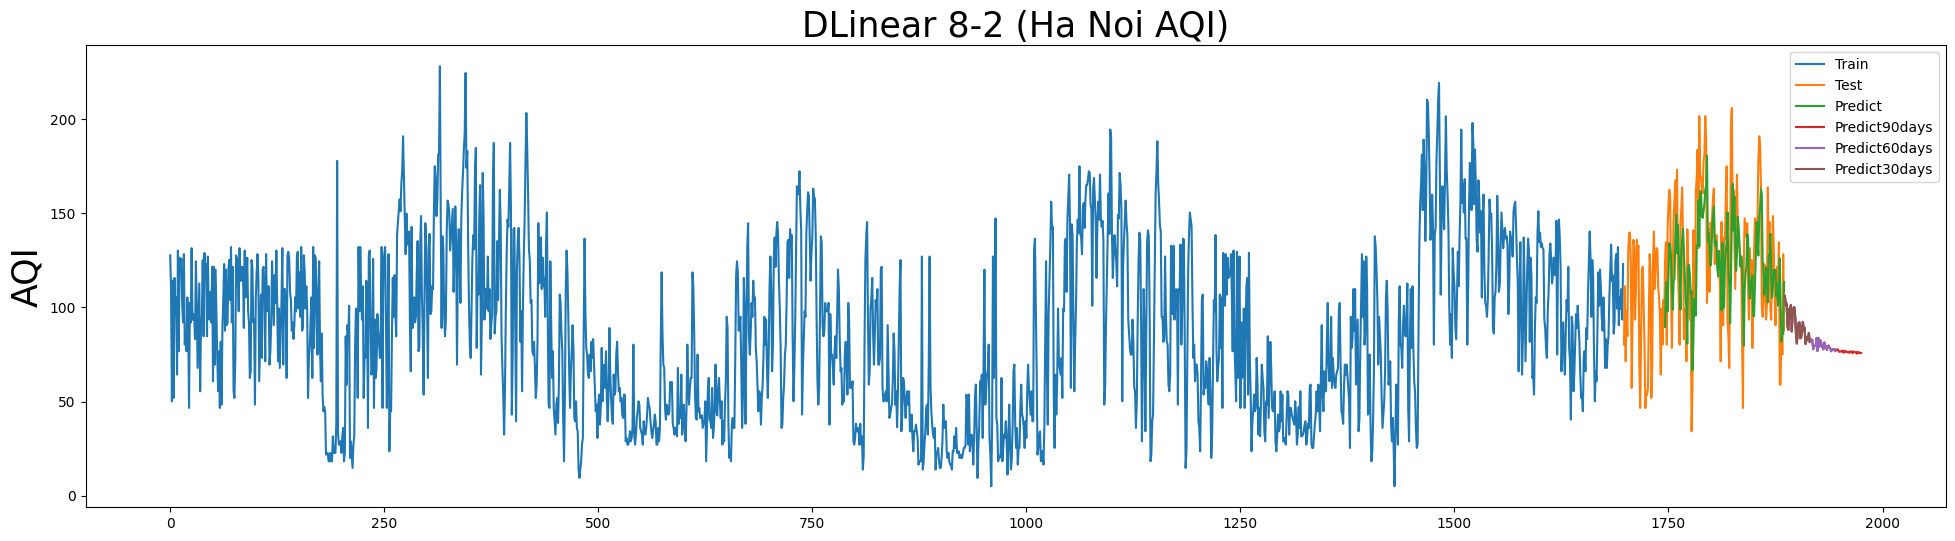

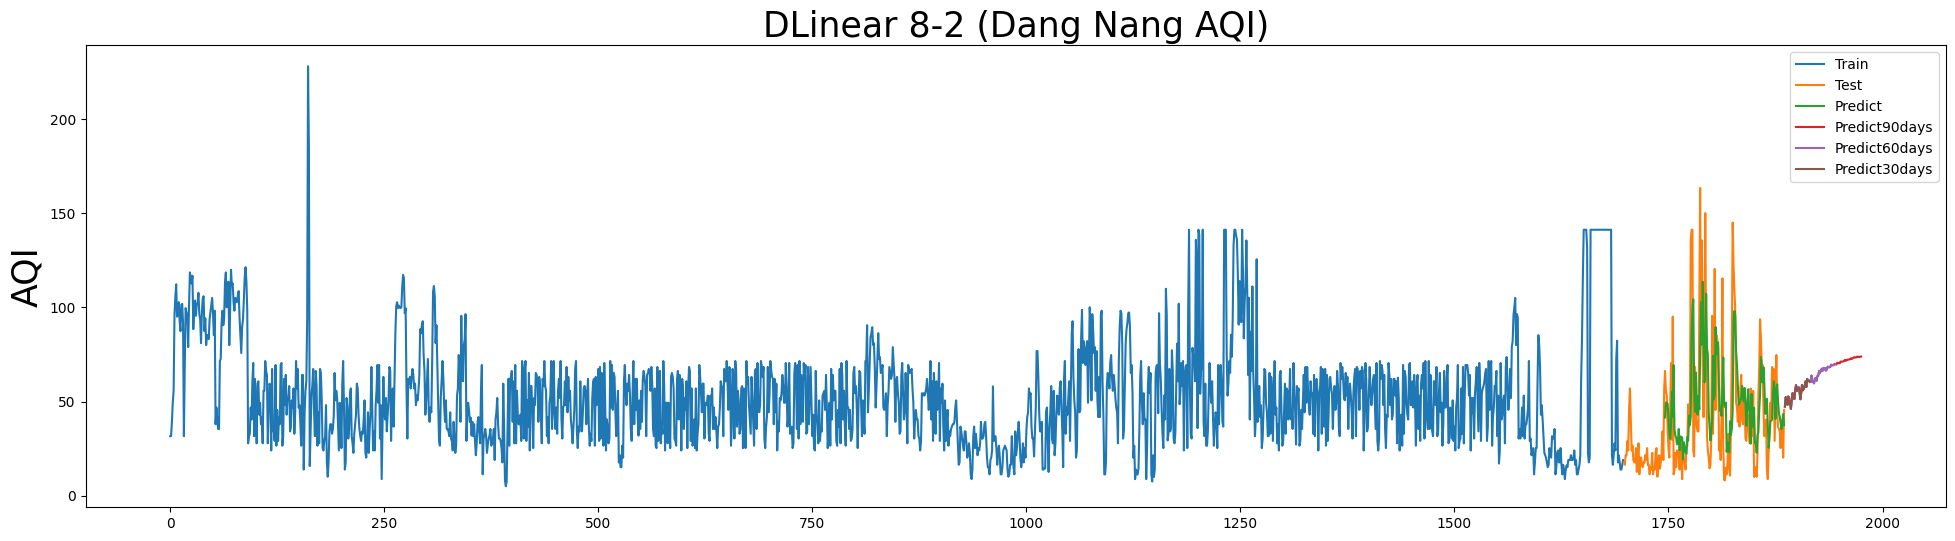

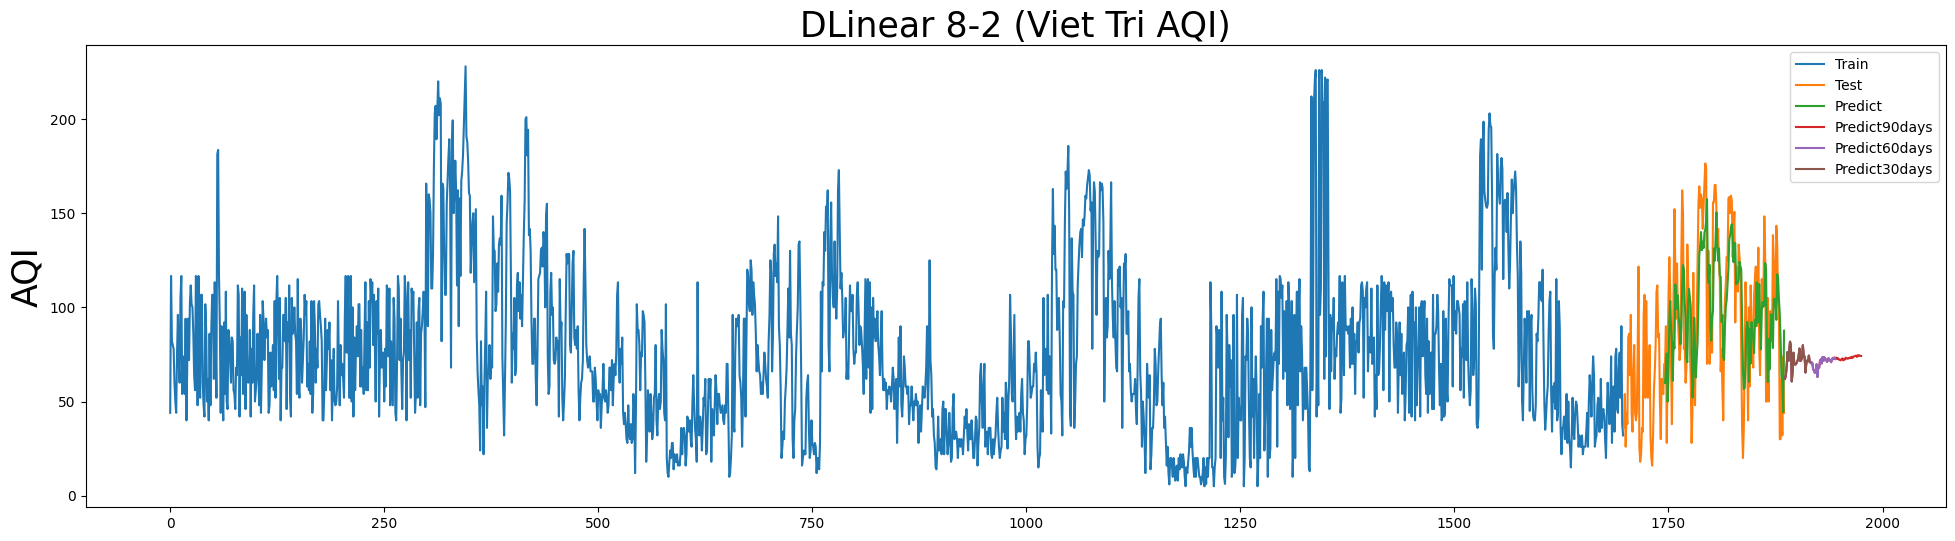

In [77]:
# Visualize the predictions
import matplotlib.pyplot as plt

## HaNoi
train_data_origin = scaler.inverse_transform(train_data_HaNoi)
test_data_origin = scaler.inverse_transform(test_data_HaNoi)
test_pred_origin = test_pred_HaNoi
pred_30_origin = predictions_HaNoi_30
pred_60_origin = predictions_HaNoi_60
pred_90_origin = predictions_HaNoi_90


test_data_index = pd.RangeIndex(start=len(train_data_origin), stop=len(train_data_origin)+len(test_data_origin), step=1)
test_pred_index = pd.RangeIndex(start=len(train_data_origin)+configs.seq_len+configs.pred_len-1, stop=len(train_data_origin)+len(test_data_origin), step=1)
pred_30_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+30, step=1)
pred_60_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+60, step=1)
pred_90_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+90, step=1)

plt.figure(figsize=(24, 6))
plt.title('DLinear 8-2 (Ha Noi AQI)', fontsize=25)
plt.ylabel('AQI', fontsize=25)

plt.plot(train_data_origin)
plt.plot(test_data_index, test_data_origin)
plt.plot(test_pred_index, test_pred_origin)
plt.plot(pred_90_index, pred_90_origin)
plt.plot(pred_60_index, pred_60_origin)
plt.plot(pred_30_index, pred_30_origin)

plt.legend(['Train','Test','Predict','Predict90days','Predict60days','Predict30days'])
#Save plot to file
plt.savefig('plot/DLinear_8-2_HaNoi.png')


## DaNang
train_data_origin = scaler.inverse_transform(train_data_DaNang)
test_data_origin = scaler.inverse_transform(test_data_DaNang)
test_pred_origin = test_pred_DaNang
pred_30_origin = predictions_DaNang_30
pred_60_origin = predictions_DaNang_60
pred_90_origin = predictions_DaNang_90

test_data_index = pd.RangeIndex(start=len(train_data_origin), stop=len(train_data_origin)+len(test_data_origin), step=1)
test_pred_index = pd.RangeIndex(start=len(train_data_origin)+configs.seq_len+configs.pred_len-1, stop=len(train_data_origin)+len(test_data_origin), step=1)
pred_30_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+30, step=1)
pred_60_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+60, step=1)
pred_90_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+90, step=1)

plt.figure(figsize=(24, 6))
plt.title('DLinear 8-2 (Dang Nang AQI)', fontsize=25)
plt.ylabel('AQI', fontsize=25)

plt.plot(train_data_origin)
plt.plot(test_data_index, test_data_origin)
plt.plot(test_pred_index, test_pred_origin)
plt.plot(pred_90_index, pred_90_origin)
plt.plot(pred_60_index, pred_60_origin)
plt.plot(pred_30_index, pred_30_origin)

plt.legend(['Train','Test','Predict','Predict90days','Predict60days','Predict30days'])
#Save plot to file
plt.savefig('plot/DLinear_8-2_DaNang.png')
## VietTri
train_data_origin = scaler.inverse_transform(train_data_VietTri)
test_data_origin = scaler.inverse_transform(test_data_VietTri)
test_pred_origin = test_pred_VietTri
pred_30_origin = predictions_VietTri_30
pred_60_origin = predictions_VietTri_60
pred_90_origin = predictions_VietTri_90

test_data_index = pd.RangeIndex(start=len(train_data_origin), stop=len(train_data_origin)+len(test_data_origin), step=1)
test_pred_index = pd.RangeIndex(start=len(train_data_origin)+configs.seq_len+configs.pred_len-1, stop=len(train_data_origin)+len(test_data_origin), step=1)
pred_30_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+30, step=1)
pred_60_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+60, step=1)
pred_90_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+90, step=1)

plt.figure(figsize=(24, 6))
plt.title('DLinear 8-2 (Viet Tri AQI)', fontsize=25)
plt.ylabel('AQI', fontsize=25)

plt.plot(train_data_origin)
plt.plot(test_data_index, test_data_origin)
plt.plot(test_pred_index, test_pred_origin)
plt.plot(pred_90_index, pred_90_origin)
plt.plot(pred_60_index, pred_60_origin)
plt.plot(pred_30_index, pred_30_origin)

plt.legend(['Train','Test','Predict','Predict90days','Predict60days','Predict30days'])
#Save plot to file
plt.savefig('plot/DLinear_8-2_VietTri.png')



In [70]:
#tính RMSE,MAPE,MAE cho tâp test
from sklearn.metrics import mean_squared_error
from math import sqrt

## HaNoi
print('HaNoi')
test_data_origin = scaler.inverse_transform(test_data_HaNoi)
test_pred_origin = test_pred_HaNoi

test_data_origin_1 = test_data_origin[configs.seq_len+configs.pred_len-1:]
rmse = sqrt(mean_squared_error(test_pred_origin, test_data_origin_1))
mape = np.mean(np.abs((test_pred_origin - test_data_origin_1) /test_data_origin_1)) * 100
mae = np.mean(np.abs(test_pred_origin - test_data_origin_1))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)

print('DaNang')
test_data_origin = scaler.inverse_transform(test_data_DaNang)
test_pred_origin = test_pred_DaNang

test_data_origin_1 = test_data_origin[configs.seq_len+configs.pred_len-1:]
rmse = sqrt(mean_squared_error(test_pred_origin, test_data_origin_1))
mape = np.mean(np.abs((test_pred_origin - test_data_origin_1) /test_data_origin_1)) * 100
mae = np.mean(np.abs(test_pred_origin - test_data_origin_1))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)

## VietTri
print('VietTri')
test_data_origin = scaler.inverse_transform(test_data_VietTri)
test_pred_origin = test_pred_VietTri

test_data_origin_1 = test_data_origin[configs.seq_len+configs.pred_len-1:]
rmse = sqrt(mean_squared_error(test_pred_origin, test_data_origin_1))
mape = np.mean(np.abs((test_pred_origin - test_data_origin_1) /test_data_origin_1)) * 100
mae = np.mean(np.abs(test_pred_origin - test_data_origin_1))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)


HaNoi
Test RMSE: 27.289
Test MAPE: 22.192
Test MAE: 21.983
DaNang
Test RMSE: 26.027
Test MAPE: 60.890
Test MAE: 18.226
VietTri
Test RMSE: 27.116
Test MAPE: 37.012
Test MAE: 21.710


### Với tỉ lệ 9 - 1

In [71]:
#splitting dataset into train and test split
split_size = 0.9

## HaNoi
train_size= int(split_size * len(df_Hanoi))
test_size = int((1-split_size) * len(df_Hanoi))

train_data_HaNoi = df1_HaNoi[:train_size]
test_data_HaNoi = df1_HaNoi[train_size:train_size+test_size]

## DaNang
train_size= int(split_size * len(df_DaNang))
test_size = int((1-split_size) * len(df_DaNang))

train_data_DaNang = df1_DaNang[:train_size]
test_data_DaNang = df1_DaNang[train_size:train_size+test_size]

## VietTri
train_size= int(split_size * len(df_VietTri))
test_size = int((1-split_size) * len(df_VietTri))

train_data_VietTri = df1_VietTri[:train_size]
test_data_VietTri = df1_VietTri[train_size:train_size+test_size]



In [72]:
#train model
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from tqdm import tqdm
# Hyperparameters
seq_len = configs.seq_len  
pred_len =  configs.pred_len
batch_size = 64
num_epochs = 100
learning_rate = 0.003
individual = False


#fit model for HaNoi
model_HaNoi = fit(model, train_data_HaNoi, test_data_HaNoi, seq_len, pred_len, batch_size, num_epochs, learning_rate)

#fit model for DaNang
model_DaNang = fit(model, train_data_DaNang, test_data_DaNang, seq_len, pred_len, batch_size, num_epochs, learning_rate)

#fit model for VietTri
model_VietTri = fit(model, train_data_VietTri, test_data_VietTri, seq_len, pred_len, batch_size, num_epochs, learning_rate)


c:\Users\Hung\miniconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch [0/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0151] 

Epoch 1/100, Train Loss: 0.0151, Test Loss: 0.0200


Epoch [0/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0151]


Epoch 2/100, Train Loss: 0.0137, Test Loss: 0.0193


Epoch [2/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.012]  

Epoch 3/100, Train Loss: 0.0133, Test Loss: 0.0192


Epoch [2/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.012]


Epoch 4/100, Train Loss: 0.0131, Test Loss: 0.0191


Epoch [4/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0156] 

Epoch 5/100, Train Loss: 0.0132, Test Loss: 0.0193


Epoch [4/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0156]


Epoch 6/100, Train Loss: 0.0133, Test Loss: 0.0194


Epoch [6/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0195] 

Epoch 7/100, Train Loss: 0.0134, Test Loss: 0.0208


Epoch [6/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0195]


Epoch 8/100, Train Loss: 0.0131, Test Loss: 0.0204


Epoch [8/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0191]

Epoch 9/100, Train Loss: 0.0132, Test Loss: 0.0193


Epoch [8/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0191]


Epoch 10/100, Train Loss: 0.0134, Test Loss: 0.0195


Epoch [10/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0124] 

Epoch 11/100, Train Loss: 0.0132, Test Loss: 0.0199


Epoch [10/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0124]


Epoch 12/100, Train Loss: 0.0130, Test Loss: 0.0193


Epoch [12/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00963]

Epoch 13/100, Train Loss: 0.0130, Test Loss: 0.0198


Epoch [12/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00963]


Epoch 14/100, Train Loss: 0.0130, Test Loss: 0.0193


Epoch [14/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.011]  

Epoch 15/100, Train Loss: 0.0129, Test Loss: 0.0193


Epoch [14/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.011]


Epoch 16/100, Train Loss: 0.0129, Test Loss: 0.0195


Epoch [16/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0136]

Epoch 17/100, Train Loss: 0.0130, Test Loss: 0.0195


Epoch [16/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0136]


Epoch 18/100, Train Loss: 0.0128, Test Loss: 0.0196


Epoch [18/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.012]  

Epoch 19/100, Train Loss: 0.0130, Test Loss: 0.0193


Epoch [18/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.012]


Epoch 20/100, Train Loss: 0.0129, Test Loss: 0.0195


Epoch [20/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0125] 

Epoch 21/100, Train Loss: 0.0130, Test Loss: 0.0193


Epoch [20/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0125]


Epoch 22/100, Train Loss: 0.0129, Test Loss: 0.0196


Epoch [22/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0107] 

Epoch 23/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [22/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0107]


Epoch 24/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [24/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0104] 

Epoch 25/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [24/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0104]


Epoch 26/100, Train Loss: 0.0129, Test Loss: 0.0194


Epoch [26/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0177] 

Epoch 27/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [26/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0177]


Epoch 28/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [28/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0168] 

Epoch 29/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [28/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0168]


Epoch 30/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [30/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0145] 

Epoch 31/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [30/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0145]


Epoch 32/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [32/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00729]

Epoch 33/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [32/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00729]


Epoch 34/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [34/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0145] 

Epoch 35/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [34/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0145]


Epoch 36/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [36/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00927]

Epoch 37/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [36/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00927]


Epoch 38/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [38/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0106] 

Epoch 39/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [38/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0106]


Epoch 40/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [40/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0123] 

Epoch 41/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [40/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0123]


Epoch 42/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [42/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00942]

Epoch 43/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [42/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00942]


Epoch 44/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [44/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00919]

Epoch 45/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [44/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00919]


Epoch 46/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [46/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.013]  

Epoch 47/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [46/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.013]


Epoch 48/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [48/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0101] 

Epoch 49/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [48/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0101]


Epoch 50/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [50/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00874]

Epoch 51/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [50/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00874]


Epoch 52/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [52/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0113] 

Epoch 53/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [52/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0113]


Epoch 54/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [54/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0118] 

Epoch 55/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [54/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0118]


Epoch 56/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [56/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00807]

Epoch 57/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [56/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00807]


Epoch 58/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [58/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00902]

Epoch 59/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [58/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00902]


Epoch 60/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [60/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0172] 

Epoch 61/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [60/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0172]


Epoch 62/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [62/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0143] 

Epoch 63/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [62/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0143]


Epoch 64/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [64/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0195] 

Epoch 65/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [64/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0195]


Epoch 66/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [66/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0129] 

Epoch 67/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [66/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0129]


Epoch 68/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [68/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0165] 

Epoch 69/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [68/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0165]


Epoch 70/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [70/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00966]

Epoch 71/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [70/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00966]


Epoch 72/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [72/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0111] 

Epoch 73/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [72/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0111]


Epoch 74/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [74/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0147] 

Epoch 75/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [74/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0147]


Epoch 76/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [76/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00864]

Epoch 77/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [76/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00864]


Epoch 78/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [78/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0129] 

Epoch 79/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [78/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0129]


Epoch 80/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [80/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00807]

Epoch 81/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [80/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00807]


Epoch 82/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [82/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0165] 

Epoch 83/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [82/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0165]


Epoch 84/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [84/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0104] 

Epoch 85/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [84/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0104]


Epoch 86/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [86/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0134] 

Epoch 87/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [86/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0134]


Epoch 88/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [88/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00949]

Epoch 89/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [88/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00949]


Epoch 90/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [90/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0121] 

Epoch 91/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [90/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0121]


Epoch 92/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [92/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0167] 

Epoch 93/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [92/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0167]


Epoch 94/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [94/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0126] 

Epoch 95/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [94/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0126]


Epoch 96/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [96/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.01]   

Epoch 97/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [96/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.01]


Epoch 98/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [98/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0108] 

Epoch 99/100, Train Loss: 0.0127, Test Loss: 0.0193


Epoch [99/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.013]


Epoch 100/100, Train Loss: 0.0128, Test Loss: 0.0193


Epoch [0/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00563]

Epoch 1/100, Train Loss: 0.0083, Test Loss: 0.0143


Epoch [0/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00563]


Epoch 2/100, Train Loss: 0.0079, Test Loss: 0.0150


Epoch [2/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00462]

Epoch 3/100, Train Loss: 0.0076, Test Loss: 0.0146


Epoch [2/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00462]


Epoch 4/100, Train Loss: 0.0075, Test Loss: 0.0145


Epoch [4/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00685]

Epoch 5/100, Train Loss: 0.0074, Test Loss: 0.0145


Epoch [4/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00685]


Epoch 6/100, Train Loss: 0.0075, Test Loss: 0.0148


Epoch [6/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0124] 

Epoch 7/100, Train Loss: 0.0075, Test Loss: 0.0144


Epoch [6/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0124]


Epoch 8/100, Train Loss: 0.0074, Test Loss: 0.0147


Epoch [8/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00934]

Epoch 9/100, Train Loss: 0.0073, Test Loss: 0.0147


Epoch [8/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00934]


Epoch 10/100, Train Loss: 0.0073, Test Loss: 0.0149


Epoch [10/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00618]

Epoch 11/100, Train Loss: 0.0073, Test Loss: 0.0147


Epoch [10/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00618]


Epoch 12/100, Train Loss: 0.0073, Test Loss: 0.0146


Epoch [12/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00692]

Epoch 13/100, Train Loss: 0.0073, Test Loss: 0.0147


Epoch [12/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00692]


Epoch 14/100, Train Loss: 0.0073, Test Loss: 0.0147


Epoch [14/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00814]

Epoch 15/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [14/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00814]


Epoch 16/100, Train Loss: 0.0073, Test Loss: 0.0145


Epoch [16/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0159] 

Epoch 17/100, Train Loss: 0.0073, Test Loss: 0.0146


Epoch [16/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0159]


Epoch 18/100, Train Loss: 0.0072, Test Loss: 0.0147


Epoch [18/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00499]

Epoch 19/100, Train Loss: 0.0073, Test Loss: 0.0149


Epoch [18/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00499]


Epoch 20/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [20/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00981]

Epoch 21/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [20/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00981]


Epoch 22/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [22/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00396]

Epoch 23/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [22/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00396]


Epoch 24/100, Train Loss: 0.0073, Test Loss: 0.0146


Epoch [24/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00525]

Epoch 25/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [24/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00525]


Epoch 26/100, Train Loss: 0.0072, Test Loss: 0.0147


Epoch [26/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00754]

Epoch 27/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [26/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00754]


Epoch 28/100, Train Loss: 0.0072, Test Loss: 0.0147


Epoch [28/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00763]

Epoch 29/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [28/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00763]


Epoch 30/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [30/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0097] 

Epoch 31/100, Train Loss: 0.0073, Test Loss: 0.0147


Epoch [30/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0097]


Epoch 32/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [32/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0103] 

Epoch 33/100, Train Loss: 0.0072, Test Loss: 0.0147


Epoch [32/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0103]


Epoch 34/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [34/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0055] 

Epoch 35/100, Train Loss: 0.0072, Test Loss: 0.0147


Epoch [34/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0055]


Epoch 36/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [36/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00664]

Epoch 37/100, Train Loss: 0.0072, Test Loss: 0.0147


Epoch [36/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00664]


Epoch 38/100, Train Loss: 0.0072, Test Loss: 0.0147


Epoch [38/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0041] 

Epoch 39/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [38/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0041]


Epoch 40/100, Train Loss: 0.0072, Test Loss: 0.0147


Epoch [40/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00544]

Epoch 41/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [40/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00544]


Epoch 42/100, Train Loss: 0.0073, Test Loss: 0.0146


Epoch [42/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00523]

Epoch 43/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [42/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00523]


Epoch 44/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [44/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0126] 

Epoch 45/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [44/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0126]


Epoch 46/100, Train Loss: 0.0072, Test Loss: 0.0147


Epoch [46/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0056] 

Epoch 47/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [46/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0056]


Epoch 48/100, Train Loss: 0.0072, Test Loss: 0.0147


Epoch [48/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00605]

Epoch 49/100, Train Loss: 0.0072, Test Loss: 0.0147


Epoch [48/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00605]


Epoch 50/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [50/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00671]

Epoch 51/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [50/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00671]


Epoch 52/100, Train Loss: 0.0072, Test Loss: 0.0147


Epoch [52/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00649]

Epoch 53/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [52/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00649]


Epoch 54/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [54/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00981]

Epoch 55/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [54/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00981]


Epoch 56/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [56/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00878]

Epoch 57/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [56/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00878]


Epoch 58/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [58/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00474]

Epoch 59/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [58/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00474]


Epoch 60/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [60/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00658]

Epoch 61/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [60/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00658]


Epoch 62/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [62/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00494]

Epoch 63/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [62/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00494]


Epoch 64/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [64/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00975]

Epoch 65/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [64/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00975]


Epoch 66/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [66/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00475]

Epoch 67/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [66/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00475]


Epoch 68/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [68/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00614]

Epoch 69/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [68/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00614]


Epoch 70/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [70/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0067] 

Epoch 71/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [70/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0067]


Epoch 72/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [72/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.006]  

Epoch 73/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [72/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.006]


Epoch 74/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [74/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00662]

Epoch 75/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [74/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00662]


Epoch 76/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [76/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00708]

Epoch 77/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [76/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00708]


Epoch 78/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [78/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00908]

Epoch 79/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [78/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00908]


Epoch 80/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [80/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00553]

Epoch 81/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [80/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00553]


Epoch 82/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [82/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00616]

Epoch 83/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [82/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00616]


Epoch 84/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [84/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00721]

Epoch 85/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [84/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00721]


Epoch 86/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [86/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0165] 

Epoch 87/100, Train Loss: 0.0073, Test Loss: 0.0146


Epoch [86/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0165]


Epoch 88/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [88/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00634]

Epoch 89/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [88/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00634]


Epoch 90/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [90/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00517]

Epoch 91/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [90/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00517]


Epoch 92/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [92/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00447]

Epoch 93/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [92/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00447]


Epoch 94/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [94/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0185] 

Epoch 95/100, Train Loss: 0.0073, Test Loss: 0.0146


Epoch [94/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0185]


Epoch 96/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [96/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00534]

Epoch 97/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [96/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00534]


Epoch 98/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [98/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00572]

Epoch 99/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [98/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00572]


Epoch 100/100, Train Loss: 0.0072, Test Loss: 0.0146


Epoch [0/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0208]

Epoch 1/100, Train Loss: 0.0169, Test Loss: 0.0195


Epoch [0/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0208]


Epoch 2/100, Train Loss: 0.0161, Test Loss: 0.0196


Epoch [2/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0265] 

Epoch 3/100, Train Loss: 0.0156, Test Loss: 0.0210


Epoch [2/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0265]


Epoch 4/100, Train Loss: 0.0159, Test Loss: 0.0203


Epoch [4/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0234] 

Epoch 5/100, Train Loss: 0.0158, Test Loss: 0.0213


Epoch [4/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0234]


Epoch 6/100, Train Loss: 0.0155, Test Loss: 0.0215


Epoch [6/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0119]

Epoch 7/100, Train Loss: 0.0159, Test Loss: 0.0204


Epoch [6/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0119]


Epoch 8/100, Train Loss: 0.0152, Test Loss: 0.0207


Epoch [8/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0174] 

Epoch 9/100, Train Loss: 0.0154, Test Loss: 0.0203


Epoch [8/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0174]


Epoch 10/100, Train Loss: 0.0154, Test Loss: 0.0206


Epoch [10/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0112]

Epoch 11/100, Train Loss: 0.0152, Test Loss: 0.0205


Epoch [10/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0112]


Epoch 12/100, Train Loss: 0.0152, Test Loss: 0.0207


Epoch [12/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.016] 

Epoch 13/100, Train Loss: 0.0157, Test Loss: 0.0205


Epoch [12/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.016]


Epoch 14/100, Train Loss: 0.0152, Test Loss: 0.0204


Epoch [14/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0116]

Epoch 15/100, Train Loss: 0.0151, Test Loss: 0.0204


Epoch [14/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0116]


Epoch 16/100, Train Loss: 0.0152, Test Loss: 0.0205


Epoch [16/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0175] 

Epoch 17/100, Train Loss: 0.0152, Test Loss: 0.0205


Epoch [16/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0175]


Epoch 18/100, Train Loss: 0.0152, Test Loss: 0.0206


Epoch [18/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.018]  

Epoch 19/100, Train Loss: 0.0151, Test Loss: 0.0204


Epoch [18/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.018]


Epoch 20/100, Train Loss: 0.0151, Test Loss: 0.0205


Epoch [20/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.015]  

Epoch 21/100, Train Loss: 0.0151, Test Loss: 0.0207


Epoch [20/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.015]


Epoch 22/100, Train Loss: 0.0151, Test Loss: 0.0204


Epoch [22/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0137] 

Epoch 23/100, Train Loss: 0.0150, Test Loss: 0.0206


Epoch [22/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0137]


Epoch 24/100, Train Loss: 0.0153, Test Loss: 0.0205


Epoch [24/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0151] 

Epoch 25/100, Train Loss: 0.0151, Test Loss: 0.0206


Epoch [24/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0151]


Epoch 26/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [26/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0169] 

Epoch 27/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [26/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0169]


Epoch 28/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [28/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0147] 

Epoch 29/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [28/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0147]


Epoch 30/100, Train Loss: 0.0151, Test Loss: 0.0205


Epoch [30/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0148] 

Epoch 31/100, Train Loss: 0.0150, Test Loss: 0.0206


Epoch [30/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0148]


Epoch 32/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [32/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0134] 

Epoch 33/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [32/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0134]


Epoch 34/100, Train Loss: 0.0151, Test Loss: 0.0205


Epoch [34/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0147] 

Epoch 35/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [34/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0147]


Epoch 36/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [36/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0151] 

Epoch 37/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [36/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0151]


Epoch 38/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [38/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0112] 

Epoch 39/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [38/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0112]


Epoch 40/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [40/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0124] 

Epoch 41/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [40/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0124]


Epoch 42/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [42/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0136] 

Epoch 43/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [42/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0136]


Epoch 44/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [44/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0175] 

Epoch 45/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [44/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0175]


Epoch 46/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [46/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0119]

Epoch 47/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [46/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0119]


Epoch 48/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [48/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0125] 

Epoch 49/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [48/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0125]


Epoch 50/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [50/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0112] 

Epoch 51/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [50/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0112]


Epoch 52/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [52/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0184] 

Epoch 53/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [52/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0184]


Epoch 54/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [54/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.019] 

Epoch 55/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [54/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.019]


Epoch 56/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [56/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0175] 

Epoch 57/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [56/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0175]


Epoch 58/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [58/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00997]

Epoch 59/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [58/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00997]


Epoch 60/100, Train Loss: 0.0151, Test Loss: 0.0205


Epoch [60/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0128] 

Epoch 61/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [60/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0128]


Epoch 62/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [62/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0104]

Epoch 63/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [62/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0104]


Epoch 64/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [64/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0111] 

Epoch 65/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [64/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0111]


Epoch 66/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [66/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0154] 

Epoch 67/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [66/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0154]


Epoch 68/100, Train Loss: 0.0151, Test Loss: 0.0205


Epoch [68/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.014]  

Epoch 69/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [68/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.014]


Epoch 70/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [70/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0078]

Epoch 71/100, Train Loss: 0.0149, Test Loss: 0.0205


Epoch [70/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0078]


Epoch 72/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [72/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0134] 

Epoch 73/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [72/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0134]


Epoch 74/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [74/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0178] 

Epoch 75/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [74/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0178]


Epoch 76/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [76/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.013]  

Epoch 77/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [76/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.013]


Epoch 78/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [78/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0136] 

Epoch 79/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [78/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0136]


Epoch 80/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [80/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0106] 

Epoch 81/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [80/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0106]


Epoch 82/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [82/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0152] 

Epoch 83/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [82/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0152]


Epoch 84/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [84/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0174] 

Epoch 85/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [84/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0174]


Epoch 86/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [86/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00988]

Epoch 87/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [86/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00988]


Epoch 88/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [88/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0116] 

Epoch 89/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [88/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0116]


Epoch 90/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [90/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0123] 

Epoch 91/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [90/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0123]


Epoch 92/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [92/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0147] 

Epoch 93/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [92/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0147]


Epoch 94/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [94/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0154] 

Epoch 95/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [94/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0154]


Epoch 96/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [96/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0142] 

Epoch 97/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [96/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0142]


Epoch 98/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [98/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0168] 

Epoch 99/100, Train Loss: 0.0150, Test Loss: 0.0205


Epoch [99/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0164]

Epoch 100/100, Train Loss: 0.0150, Test Loss: 0.0205


In [73]:
# Make predictions on the test data
test_pred_HaNoi = predict_test(model_HaNoi, test_data_HaNoi, seq_len, pred_len, batch_size)
test_pred_DaNang = predict_test(model_DaNang, test_data_DaNang, seq_len, pred_len, batch_size)
test_pred_VietTri = predict_test(model_VietTri, test_data_VietTri, seq_len, pred_len, batch_size)
# Inverse transform the predictions
test_pred_HaNoi = scaler.inverse_transform(test_pred_HaNoi)
test_pred_DaNang = scaler.inverse_transform(test_pred_DaNang)
test_pred_VietTri = scaler.inverse_transform(test_pred_VietTri)


In [74]:
## Make predictions for the next 30 days
prediction_days = 30
predictions_HaNoi_30 = predict(model_HaNoi, test_data_HaNoi, configs.seq_len, prediction_days)
predictions_DaNang_30 = predict(model_DaNang, test_data_DaNang, configs.seq_len, prediction_days)
predictions_VietTri_30 = predict(model_VietTri, test_data_VietTri, configs.seq_len, prediction_days)

# Inverse transform the predictions
predictions_HaNoi_30 = scaler.inverse_transform(predictions_HaNoi_30)
predictions_DaNang_30 = scaler.inverse_transform(predictions_DaNang_30)
predictions_VietTri_30 = scaler.inverse_transform(predictions_VietTri_30)

## Make predictions for the next 60 days
prediction_days = 60
predictions_HaNoi_60 = predict(model_HaNoi, test_data_HaNoi, configs.seq_len, prediction_days)
predictions_DaNang_60 = predict(model_DaNang, test_data_DaNang, configs.seq_len, prediction_days)
predictions_VietTri_60 = predict(model_VietTri, test_data_VietTri, configs.seq_len, prediction_days)

# Inverse transform the predictions
predictions_HaNoi_60 = scaler.inverse_transform(predictions_HaNoi_60)
predictions_DaNang_60 = scaler.inverse_transform(predictions_DaNang_60)
predictions_VietTri_60 = scaler.inverse_transform(predictions_VietTri_60)

## Make predictions for the next 90 days

prediction_days = 90
predictions_HaNoi_90 = predict(model_HaNoi, test_data_HaNoi, configs.seq_len, prediction_days)
predictions_DaNang_90 = predict(model_DaNang, test_data_DaNang, configs.seq_len, prediction_days)
predictions_VietTri_90 = predict(model_VietTri, test_data_VietTri, configs.seq_len, prediction_days)

# Inverse transform the predictions
predictions_HaNoi_90 = scaler.inverse_transform(predictions_HaNoi_90)
predictions_DaNang_90 = scaler.inverse_transform(predictions_DaNang_90)
predictions_VietTri_90 = scaler.inverse_transform(predictions_VietTri_90)


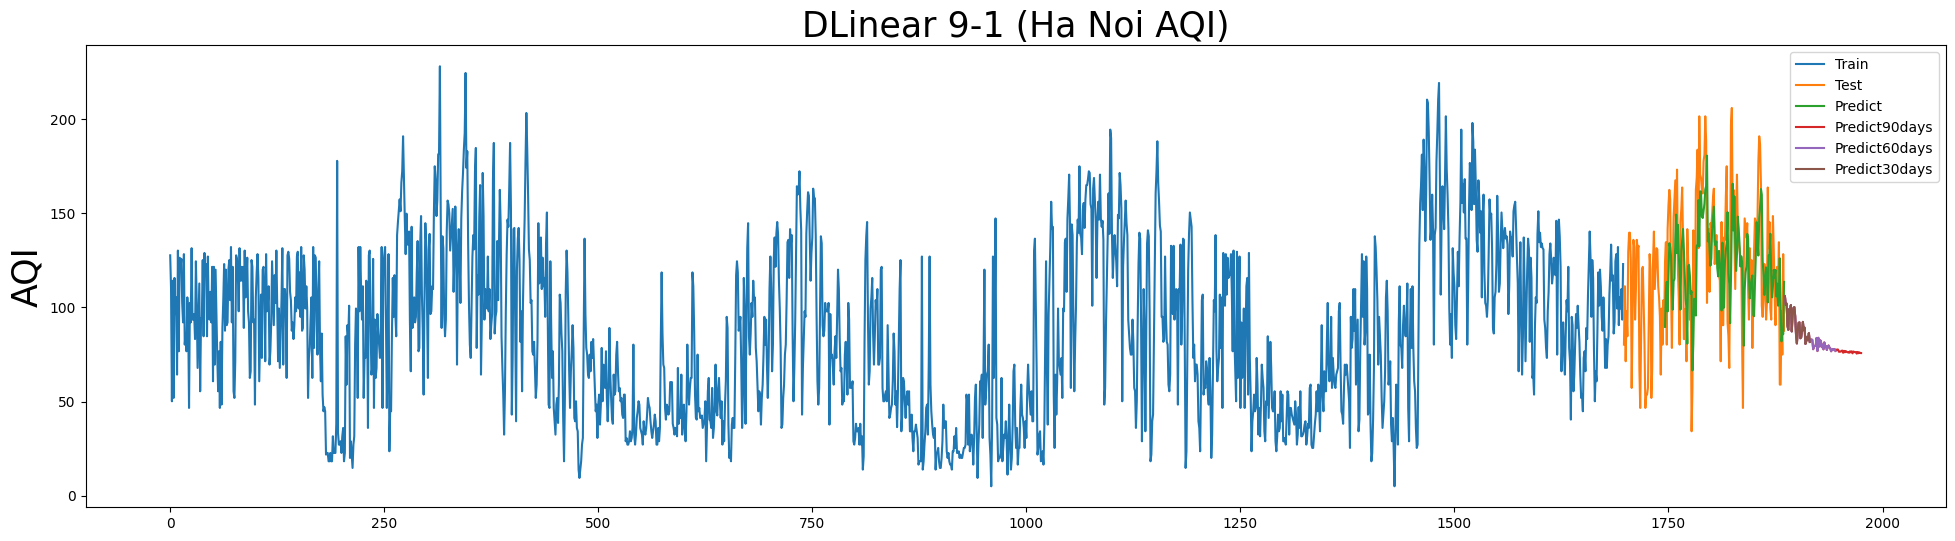

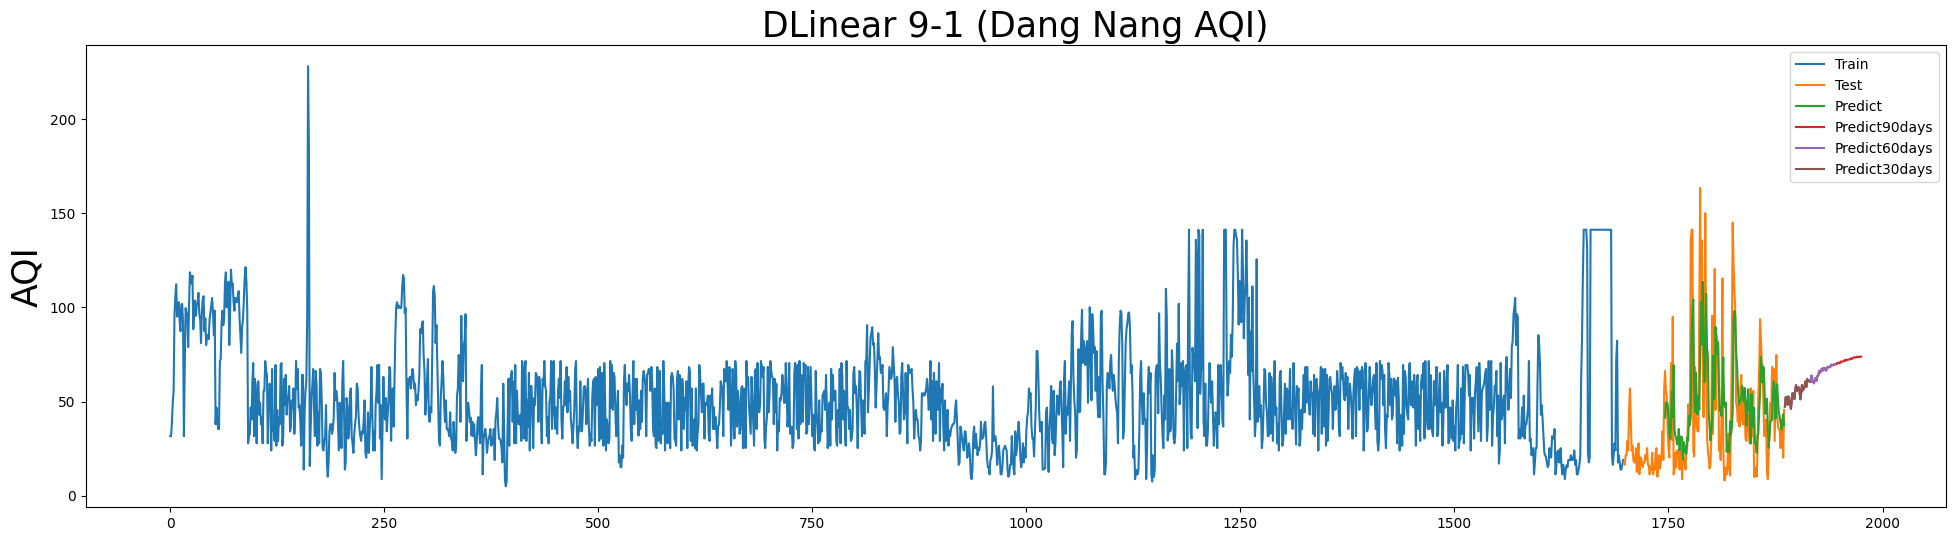

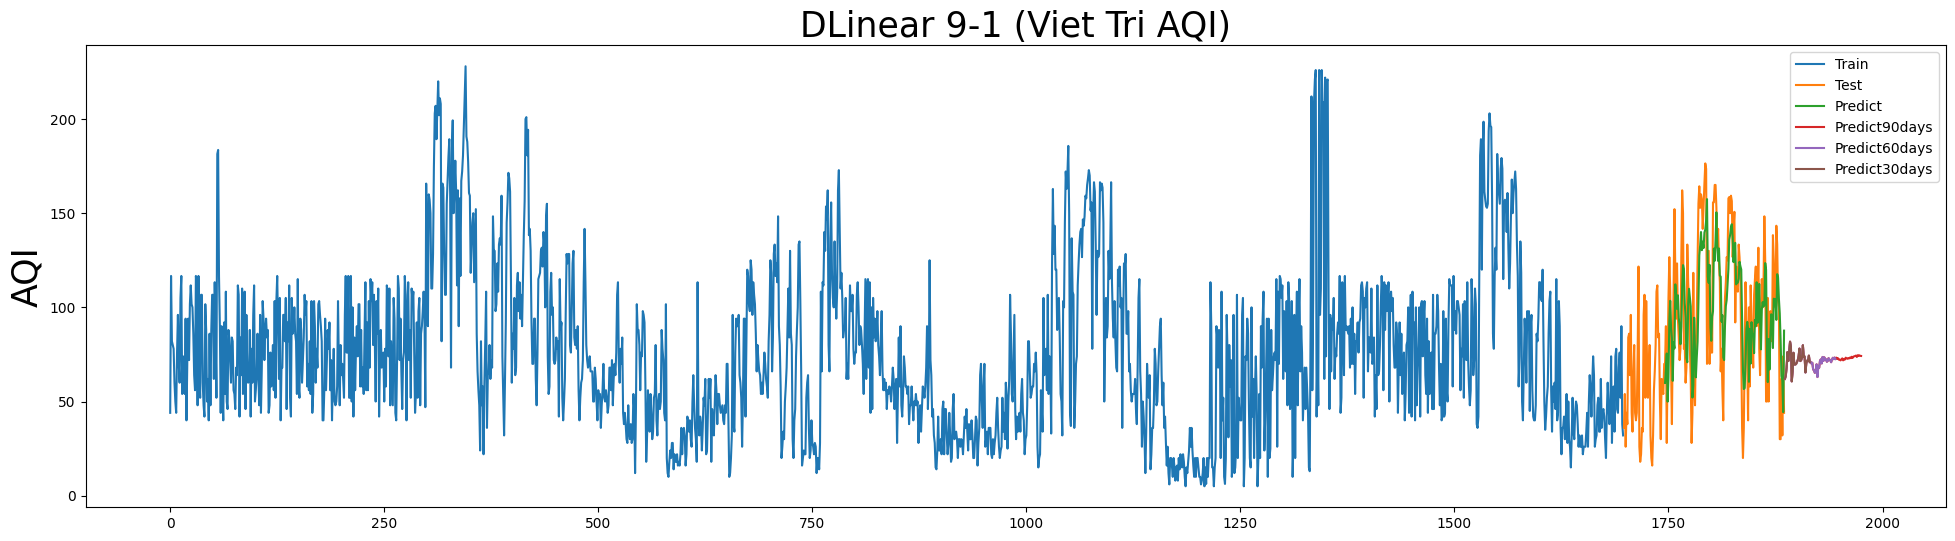

In [75]:
# Visualize the predictions
import matplotlib.pyplot as plt

## HaNoi
train_data_origin = scaler.inverse_transform(train_data_HaNoi)
test_data_origin = scaler.inverse_transform(test_data_HaNoi)
test_pred_origin = test_pred_HaNoi
pred_30_origin = predictions_HaNoi_30
pred_60_origin = predictions_HaNoi_60
pred_90_origin = predictions_HaNoi_90


test_data_index = pd.RangeIndex(start=len(train_data_origin), stop=len(train_data_origin)+len(test_data_origin), step=1)
test_pred_index = pd.RangeIndex(start=len(train_data_origin)+configs.seq_len+configs.pred_len-1, stop=len(train_data_origin)+len(test_data_origin), step=1)
pred_30_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+30, step=1)
pred_60_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+60, step=1)
pred_90_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+90, step=1)

plt.figure(figsize=(24, 6))
plt.title('DLinear 9-1 (Ha Noi AQI)', fontsize=25)
plt.ylabel('AQI', fontsize=25)

plt.plot(train_data_origin)
plt.plot(test_data_index, test_data_origin)
plt.plot(test_pred_index, test_pred_origin)
plt.plot(pred_90_index, pred_90_origin)
plt.plot(pred_60_index, pred_60_origin)
plt.plot(pred_30_index, pred_30_origin)

plt.legend(['Train','Test','Predict','Predict90days','Predict60days','Predict30days'])
#Save plot to file
plt.savefig('plot/DLinear_9-1_HaNoi.png')

## DaNang
train_data_origin = scaler.inverse_transform(train_data_DaNang)
test_data_origin = scaler.inverse_transform(test_data_DaNang)
test_pred_origin = test_pred_DaNang
pred_30_origin = predictions_DaNang_30
pred_60_origin = predictions_DaNang_60
pred_90_origin = predictions_DaNang_90

test_data_index = pd.RangeIndex(start=len(train_data_origin), stop=len(train_data_origin)+len(test_data_origin), step=1)
test_pred_index = pd.RangeIndex(start=len(train_data_origin)+configs.seq_len+configs.pred_len-1, stop=len(train_data_origin)+len(test_data_origin), step=1)
pred_30_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+30, step=1)
pred_60_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+60, step=1)
pred_90_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+90, step=1)

plt.figure(figsize=(24, 6))
plt.title('DLinear 9-1 (Dang Nang AQI)', fontsize=25)
plt.ylabel('AQI', fontsize=25)

plt.plot(train_data_origin)
plt.plot(test_data_index, test_data_origin)
plt.plot(test_pred_index, test_pred_origin)
plt.plot(pred_90_index, pred_90_origin)
plt.plot(pred_60_index, pred_60_origin)
plt.plot(pred_30_index, pred_30_origin)

plt.legend(['Train','Test','Predict','Predict90days','Predict60days','Predict30days'])
#Save plot to file
plt.savefig('plot/DLinear_9-1_DaNang.png')

## VietTri
train_data_origin = scaler.inverse_transform(train_data_VietTri)
test_data_origin = scaler.inverse_transform(test_data_VietTri)
test_pred_origin = test_pred_VietTri
pred_30_origin = predictions_VietTri_30
pred_60_origin = predictions_VietTri_60
pred_90_origin = predictions_VietTri_90

test_data_index = pd.RangeIndex(start=len(train_data_origin), stop=len(train_data_origin)+len(test_data_origin), step=1)
test_pred_index = pd.RangeIndex(start=len(train_data_origin)+configs.seq_len+configs.pred_len-1, stop=len(train_data_origin)+len(test_data_origin), step=1)
pred_30_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+30, step=1)
pred_60_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+60, step=1)
pred_90_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+90, step=1)

plt.figure(figsize=(24, 6))
plt.title('DLinear 9-1 (Viet Tri AQI)', fontsize=25)
plt.ylabel('AQI', fontsize=25)

plt.plot(train_data_origin)
plt.plot(test_data_index, test_data_origin)
plt.plot(test_pred_index, test_pred_origin)
plt.plot(pred_90_index, pred_90_origin)
plt.plot(pred_60_index, pred_60_origin)
plt.plot(pred_30_index, pred_30_origin)

plt.legend(['Train','Test','Predict','Predict90days','Predict60days','Predict30days'])
#Save plot to file
plt.savefig('plot/DLinear_9-1_VietTri.png')



In [76]:
#tính RMSE,MAPE,MAE cho tâp test
from sklearn.metrics import mean_squared_error
from math import sqrt

## HaNoi
print('HaNoi')
test_data_origin = scaler.inverse_transform(test_data_HaNoi)
test_pred_origin = test_pred_HaNoi

test_data_origin_1 = test_data_origin[configs.seq_len+configs.pred_len-1:]
rmse = sqrt(mean_squared_error(test_pred_origin, test_data_origin_1))
mape = np.mean(np.abs((test_pred_origin - test_data_origin_1) /test_data_origin_1)) * 100
mae = np.mean(np.abs(test_pred_origin - test_data_origin_1))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)

print('DaNang')
test_data_origin = scaler.inverse_transform(test_data_DaNang)
test_pred_origin = test_pred_DaNang

test_data_origin_1 = test_data_origin[configs.seq_len+configs.pred_len-1:]
rmse = sqrt(mean_squared_error(test_pred_origin, test_data_origin_1))
mape = np.mean(np.abs((test_pred_origin - test_data_origin_1) /test_data_origin_1)) * 100
mae = np.mean(np.abs(test_pred_origin - test_data_origin_1))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)

## VietTri
print('VietTri')
test_data_origin = scaler.inverse_transform(test_data_VietTri)
test_pred_origin = test_pred_VietTri

test_data_origin_1 = test_data_origin[configs.seq_len+configs.pred_len-1:]
rmse = sqrt(mean_squared_error(test_pred_origin, test_data_origin_1))
mape = np.mean(np.abs((test_pred_origin - test_data_origin_1) /test_data_origin_1)) * 100
mae = np.mean(np.abs(test_pred_origin - test_data_origin_1))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)


HaNoi
Test RMSE: 32.181
Test MAPE: 23.711
Test MAE: 26.369
DaNang
Test RMSE: 29.572
Test MAPE: 69.888
Test MAE: 21.819
VietTri
Test RMSE: 31.199
Test MAPE: 34.811
Test MAE: 25.621
